<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Projekt Soziale Netzwerke Analysieren:<br> Soziale Himmelskrieger
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Flurina Riner, Patrick Schürmann, Si Ben Tran im HS 2023.<br>Bachelor of Science FHNW in Data Science.
</p>

# 1 Setup & Libraries

Hier in diesem Abschnitt importieren wir die wichtigsten Libraries für unser Projekt.

In [1]:
import json
import warnings
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import pearsonr

# 2 Explorative Datenanalyse

## 2.1 Daten einlesen

Der Nachfolgende Code Abschnitt liest die strukturierten Kaggle Daten aus JSON-Dateien, extrahiert die Werte und speichert diese in ein Pandas DataFarme ab. Diese Vorangehensweise erlaubt es uns mittels Pandas die Daten besser zu manipulieren und zu analysieren.
Anschliessend erstellen wir einen Graphen Netzwerke für jede Episode und können somit die Interaktion zwischen den Charakteren visualisieren. Dies macht es für uns einfacher, Muster oder Beziehungen zu erkennen. Am Ende der Schleife wird `lst_every_episode` eine Liste von Tupeln mit Datenframes für jeden Charakter (Nodes) und Kante (Edges) enthalten, während `graph_every_episode` eine Liste von NetworkX-Graphen für jede Episode enthält. Dies ermöglicht es, die Interaktionen zwischen Charakteren in den verschiedenen "Star Wars"-Episoden zu analysieren und darzustellen und dient als Grundlage für die weitere Analyse.

In [2]:
lst_every_episode = []
graph_every_episode = []

for episode in range(1, 8):
    filename = f'data/Star Wars/starwars-episode-{episode}-interactions-allCharacters.json'
    with open(filename, 'r') as file:
        data = json.load(file)
        nodes = data['nodes']
        df_nodes = pd.DataFrame(nodes)
        df_nodes = df_nodes.reset_index(drop=False)
        df_nodes = df_nodes.rename(columns={"index": "ID"})
        edges = data['links']
        df_edges = pd.DataFrame(edges)
        lst_every_episode.append((df_nodes, df_edges))
        G = nx.Graph()
        for idx, row in df_nodes.iterrows():
            G.add_node(row['ID'], label=row['name'], size=row['value'], color=row['colour'])
        for idx, row in df_edges.iterrows():
            G.add_edge(row['source'], row['target'], weight=row['value'])
        graph_every_episode.append(G)

## 2.2 Fehlende Werte
Wir arbeiten mit einem Datensatz von Kaggle und gehen nach unserer Lektüre des Beschriebs des Datensatzes davon aus, dass dieser keine fehlenden Werte haben sollte. Wir überprüfen dies im Code unten und können bestätigen, dass keine der Episoden fehlende Werte aufweist.

In [3]:
for episode, (df_nodes, df_edges) in enumerate(lst_every_episode, start=1):

    missing_values_nodes = df_nodes.isnull().sum()
    print(f"\nEpisode {episode} - Fehlende Werte für Knoten:")
    print(missing_values_nodes)

    missing_values_edges = df_edges.isnull().sum()
    print(f"\nEpisode {episode} - Fehlende Werte für Kanten:")
    print(missing_values_edges)


Episode 1 - Fehlende Werte für Knoten:
ID        0
name      0
value     0
colour    0
dtype: int64

Episode 1 - Fehlende Werte für Kanten:
source    0
target    0
value     0
dtype: int64

Episode 2 - Fehlende Werte für Knoten:
ID        0
name      0
value     0
colour    0
dtype: int64

Episode 2 - Fehlende Werte für Kanten:
source    0
target    0
value     0
dtype: int64

Episode 3 - Fehlende Werte für Knoten:
ID        0
name      0
value     0
colour    0
dtype: int64

Episode 3 - Fehlende Werte für Kanten:
source    0
target    0
value     0
dtype: int64

Episode 4 - Fehlende Werte für Knoten:
ID        0
name      0
value     0
colour    0
dtype: int64

Episode 4 - Fehlende Werte für Kanten:
source    0
target    0
value     0
dtype: int64

Episode 5 - Fehlende Werte für Knoten:
ID        0
name      0
value     0
colour    0
dtype: int64

Episode 5 - Fehlende Werte für Kanten:
source    0
target    0
value     0
dtype: int64

Episode 6 - Fehlende Werte für Knoten:
ID        

## 2.3 Verteilungen der Daten
Wir schauen uns an, wie sich die Anzahl Kanten der Knoten verteilt. Zu prüfen, wie sich die Verteilung verhält, ist vor allem dann spannend, wenn zu sehen wäre, dass sich die Anzahl Kanten in einer Episode ganz anders verhält. Wir sehen in der untenstehenden Grafik zwar Unterschiede, allerdings keine drastischen Gegensätze. Alle Verteilungen sind leicht links schief und die Spannweite ist nie grösser als 30.

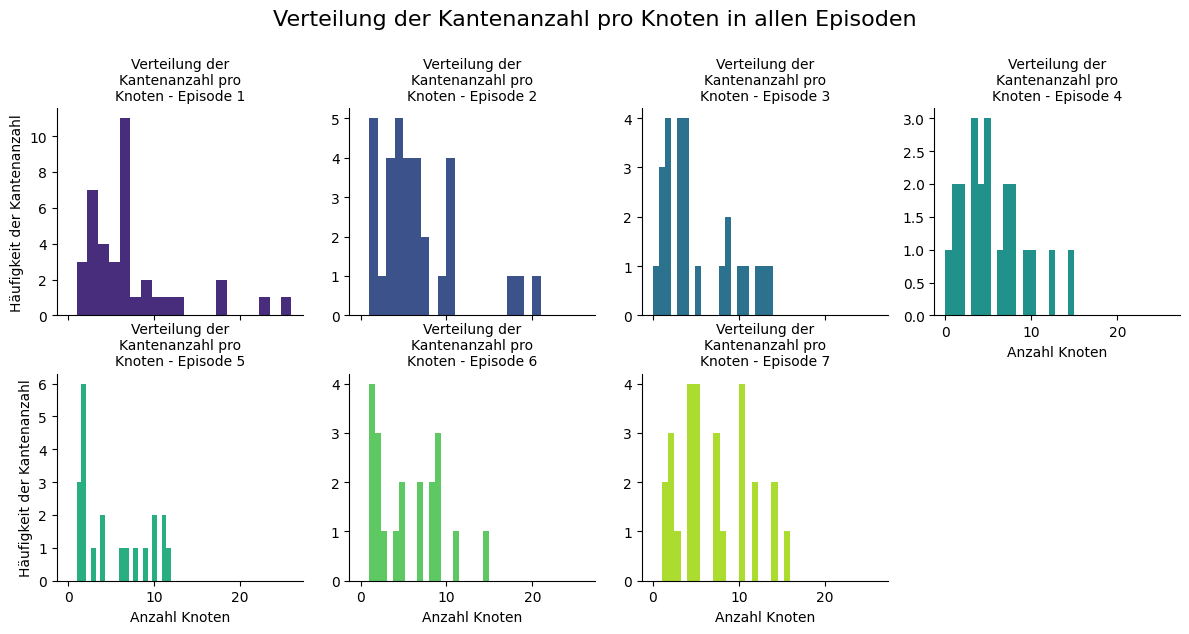

In [4]:
warnings.filterwarnings("ignore", category=FutureWarning)

degree_data = []

for episode, graph in enumerate(graph_every_episode, start=1):
    # Calculate degrees
    degrees = dict(graph.degree())
    df_degree = pd.DataFrame({'ID': list(degrees.keys()), 'Degree': list(degrees.values())})
    df_degree['Episode'] = episode
    degree_data.append(df_degree)

# Eigener DF für EDA der gesamten Episoden basteln
df_all_degree_data = pd.concat(degree_data)
#Farben für Plots festlegen (Farbenblindsicher)
colors = sns.color_palette("viridis", n_colors=len(df_all_degree_data['Episode'].unique()))

#Facetgrid erstellen für bessere Übersicht
g = sns.FacetGrid(df_all_degree_data, col="Episode", col_wrap=4, sharey=False)
g.map(plt.hist, "Degree", bins=20)

g.set_axis_labels("Anzahl Knoten", "Häufigkeit der Kantenanzahl")
g.set_titles("Verteilung der Kantenanzahl pro Knoten - Episode {col_name}")
g.fig.suptitle('Verteilung der Kantenanzahl pro Knoten in allen Episoden', fontsize=16, y=1.05)
g.tight_layout()

# Für jedes Facet Grid Element Titel und Farbe setzen
for ax, episode, color in zip(g.axes.flatten(), df_all_degree_data['Episode'].unique(), colors):
    title_text = f'Verteilung der Kantenanzahl\npro Knoten - Episode {episode}'
    ax.set_title('\n'.join(textwrap.wrap(title_text, 20)), size=10)
    for patch in ax.patches:
        patch.set_facecolor(color)

plt.show()


## 2.4 Plausibilitätsprüfungen
Ob die Daten plausibel sind, kann man auf verschiedene Weisen prüfen. Wir möchten hier vor allem sicherstellen, dass die Anzahl Knoten auch der erwarteten Anzahl Knoten respektive Kanten entspricht, um unerwartetes Verhalten zu verhindern(das haben wir auch oben schon angeschnitten, als wir fehlende Werte gezählt haben). Ebenfalls haben wir überprüft, ob die Range der Werte alle in etwa dem gleichen Bereich liegen, also ob in irgendeiner der Episoden Werte vorkommen, die astronomische (pun intended) Werte annehmen und nicht zu den anderen passen. Ebenso haben wir überprüft, ob wirklich alle Elemente des Graphen miteinander verbunden sind und nochmals ausgegeben, wie viele Kanten jeder Knoten hat um das, falls gewollt, auch nochmals von selbst überprüfen können, dass kein Knoten 0 Verbindungen hat. All unsere Analysen sind unauffällig, das heisst wir gehen davon aus, dass wir es mit plausiblen Daten zu tun haben.

In [5]:
#Checken ob die Anzahl erwarteter Knoten auch die tatsächliche Anzahl Knoten ist
for episode, (df_nodes, df_edges) in enumerate(lst_every_episode, start=1):
    num_nodes_expected = len(df_nodes)  # Adjust this based on your expectations
    num_edges_expected = len(df_edges)  # Adjust this based on your expectations

    num_nodes_actual = len(graph_every_episode[episode-1].nodes)
    num_edges_actual = len(graph_every_episode[episode-1].edges)

    print(f"\nEpisode {episode} - Expected Node Count: {num_nodes_expected}, Actual Node Count: {num_nodes_actual}")
    print(f"Episode {episode} - Expected Edge Count: {num_edges_expected}, Actual Edge Count: {num_edges_actual}")



Episode 1 - Expected Node Count: 38, Actual Node Count: 38
Episode 1 - Expected Edge Count: 135, Actual Edge Count: 135

Episode 2 - Expected Node Count: 33, Actual Node Count: 33
Episode 2 - Expected Edge Count: 101, Actual Edge Count: 101

Episode 3 - Expected Node Count: 25, Actual Node Count: 25
Episode 3 - Expected Edge Count: 65, Actual Edge Count: 65

Episode 4 - Expected Node Count: 22, Actual Node Count: 22
Episode 4 - Expected Edge Count: 60, Actual Edge Count: 60

Episode 5 - Expected Node Count: 21, Actual Node Count: 21
Episode 5 - Expected Edge Count: 55, Actual Edge Count: 55

Episode 6 - Expected Node Count: 20, Actual Node Count: 20
Episode 6 - Expected Edge Count: 55, Actual Edge Count: 55

Episode 7 - Expected Node Count: 27, Actual Node Count: 27
Episode 7 - Expected Edge Count: 92, Actual Edge Count: 92


In [6]:
#Checken ob Gewicht der Kanten und Grösse der Knoten über alle Episoden etwa die gleiche range hat.
for episode, (df_nodes, df_edges) in enumerate(lst_every_episode, start=1):

    node_size_range = (df_nodes['value'].min(), df_nodes['value'].max())
    print(f"\nEpisode {episode} - Node Size Range: {node_size_range}")

    edge_weight_range = (df_edges['value'].min(), df_edges['value'].max())
    print(f"Episode {episode} - Edge Weight Range: {edge_weight_range}")



Episode 1 - Node Size Range: (3, 61)
Episode 1 - Edge Weight Range: (1, 26)

Episode 2 - Node Size Range: (3, 40)
Episode 2 - Edge Weight Range: (1, 16)

Episode 3 - Node Size Range: (3, 60)
Episode 3 - Edge Weight Range: (1, 28)

Episode 4 - Node Size Range: (3, 89)
Episode 4 - Edge Weight Range: (1, 26)

Episode 5 - Node Size Range: (3, 51)
Episode 5 - Edge Weight Range: (1, 33)

Episode 6 - Node Size Range: (3, 33)
Episode 6 - Edge Weight Range: (1, 20)

Episode 7 - Node Size Range: (2, 64)
Episode 7 - Edge Weight Range: (1, 29)


In [7]:
for episode, graph in enumerate(graph_every_episode, start=1):
    # Prüfen ob der Graph so miteinander verbunden ist, dass alle Elemente zueinander finden können
    is_connected = nx.is_connected(graph)
    print(f"\nEpisode {episode} - Is Connected: {is_connected}")

    #Die Anzahl der Verbindungen pro Knoten wird gleich auch noch mitgegeben
    degrees = dict(graph.degree())
    print(f"Episode {episode} - Degree Distribution:")
    print(degrees)


Episode 1 - Is Connected: True
Episode 1 - Degree Distribution:
{0: 6, 1: 26, 2: 10, 3: 1, 4: 5, 5: 13, 6: 3, 7: 4, 8: 3, 9: 11, 10: 9, 11: 7, 12: 18, 13: 1, 14: 6, 15: 18, 16: 7, 17: 6, 18: 23, 19: 6, 20: 3, 21: 8, 22: 6, 23: 4, 24: 9, 25: 5, 26: 3, 27: 7, 28: 3, 29: 4, 30: 6, 31: 6, 32: 6, 33: 5, 34: 2, 35: 4, 36: 3, 37: 3}

Episode 2 - Is Connected: True
Episode 2 - Degree Distribution:
{0: 3, 1: 3, 2: 9, 3: 7, 4: 3, 5: 10, 6: 10, 7: 5, 8: 7, 9: 10, 10: 18, 11: 21, 12: 17, 13: 1, 14: 1, 15: 4, 16: 4, 17: 4, 18: 4, 19: 2, 20: 3, 21: 4, 22: 1, 23: 6, 24: 5, 25: 5, 26: 5, 27: 1, 28: 10, 29: 6, 30: 6, 31: 6, 32: 1}

Episode 3 - Is Connected: False
Episode 3 - Degree Distribution:
{0: 8, 1: 14, 2: 13, 3: 2, 4: 3, 5: 11, 6: 3, 7: 12, 8: 9, 9: 10, 10: 9, 11: 4, 12: 4, 13: 4, 14: 5, 15: 3, 16: 1, 17: 4, 18: 2, 19: 1, 20: 2, 21: 0, 22: 3, 23: 1, 24: 2}

Episode 4 - Is Connected: False
Episode 4 - Degree Distribution:
{0: 9, 1: 6, 2: 10, 3: 15, 4: 4, 5: 2, 6: 8, 7: 12, 8: 5, 9: 4, 10: 7, 11:

# 3 Netzwerkanalyse der ersten Episode

Die Funktion ``plot_episode_network`` ermöglicht es uns, ein beliebiges Netzwerk aus unseren Daten zu visualisieren. Diese Funktion erlaubt es uns erste Einblicke in das Netzwerk zu kriegen und dient als erster Anhaltspunkt unserer Netzwerk Visualisierung. Dabei haben wir zwei unterschiedliche Netzwerk Visualisierungsarten. Den Standard bzw. Normalen der mittels ``nx.draw`` oder mittels ``nx.draw_circular``. Dabei sind die beiden wichtigsten Parameter:

``graph_list``: Diese Parameter erwartet eine Liste von Graphen, aus der das gewünschte Netzwerk ausgewählt wird.  
 Die Liste ``graph_every_episode`` enthält alle NetworkX-Graphen, die wir für jede Episode erstellt haben.   
``episode_number``: Dieser Parameter gibt die Episode an, die wir visualisieren möchten. 
`view`: Wechsel zwischen den beiden Visualisierungsarten. `view = standard` für `nx.draw` und `view = circular` für `nx.draw_circular`.



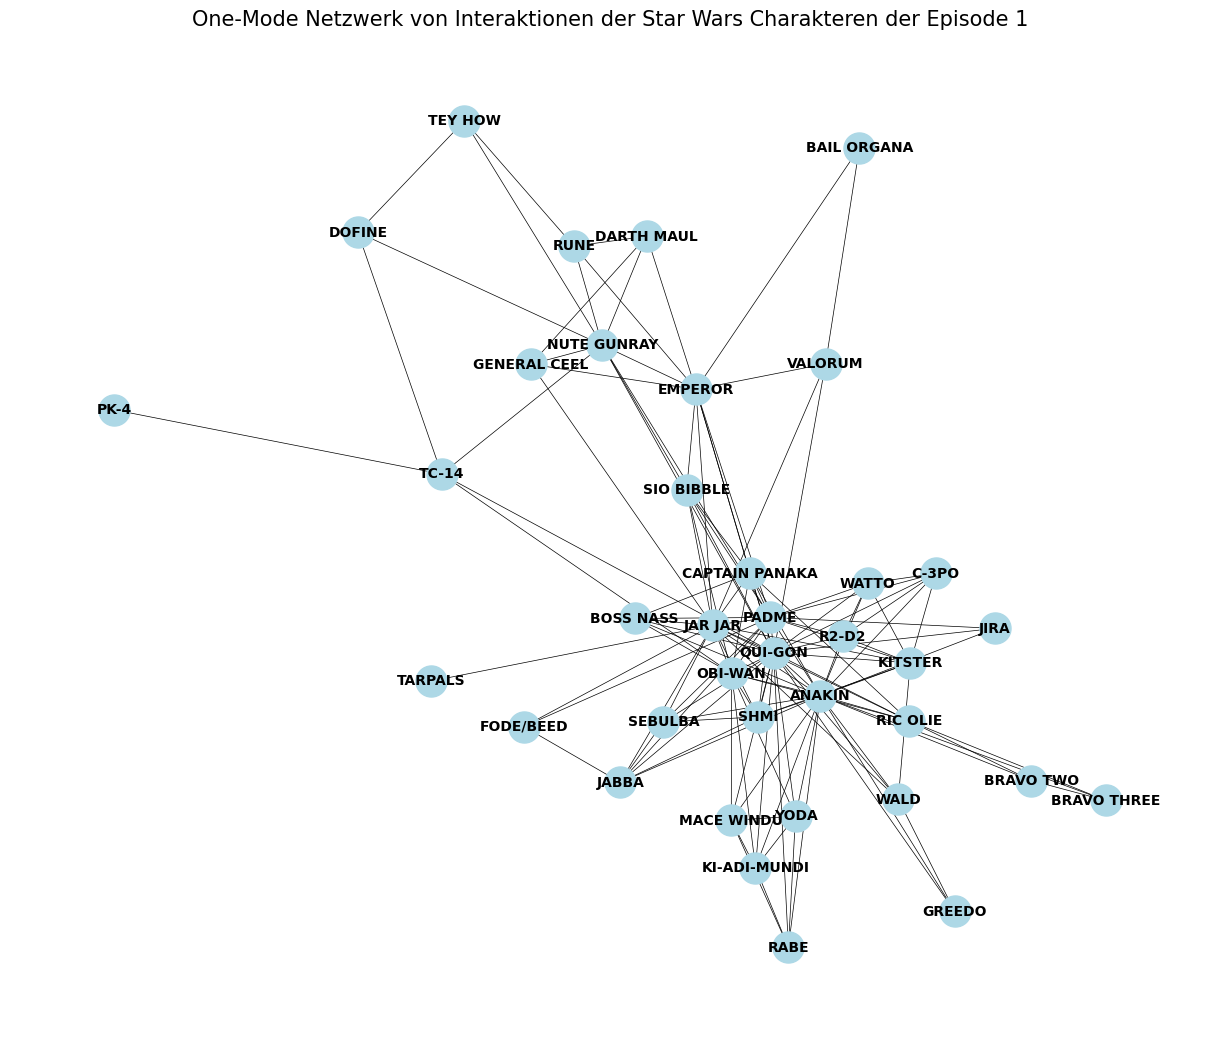

In [8]:
def plot_episode_network(graph, episode_number=None, node_colors='Lightblue'):
    if isinstance(graph, list):
        graph_episode = graph[episode_number - 1]
    else:
        graph_episode = graph
    
    labels = {node: data['label'] for node, data in graph_episode.nodes(data=True)}
    plt.figure(figsize=(12, 10))
    nx.draw(
        graph_episode,
        labels=labels,
        with_labels=True,
        node_color=node_colors,
        node_size=500,
        edge_color='black',
        font_size=10,
        font_weight='bold',
        width=0.5)
    plt.title(f"One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode {episode_number}", fontsize=15)
    plt.show()

plot_episode_network(graph = graph_every_episode, 
                     episode_number = 1)

graph_first_episode = graph_every_episode[0]

## 3.1 Lassen sich Cluster/Communities erkennen oder gar erstellen?

Praktischerweise erlaubt es uns die Library `networkx` die Communities in einem Netzwerk durch die Methode `number_connected_coponents` zu erkennen. Da wir einen ungerichteten Graphen haben ist es nicht verwunderlich, dass wir nur eine Community erkennen können. Aus diesem Grund nutzen wir dann in einem zweiten Ansatz den Edge-Betweenness Clustering Algorithmus auch bekannt aus grivan-newman. Dieser Algorithmus erlaubt es uns die Nodes in Communities zu unterteilen, dies führt der Algorithmus indem er die Edge Betweenness berechnet und die Edge mit der höchsten Betweenness entfernt. Die Funktion hat als Rückgabewert eine Liste von Listen, wobei jede Liste eine Community darstellt.

Die Funktion `get_node_groups_grivan_newman` nutzt den Algorithmus von Grivan-Newman um die Nodes in Communities zu unterteilen, der Input ist der Graph selbst. Die Funktion gibt eine Liste von Listen zurück, wobei jede Liste eine Community darstellt.

Die Funktion `create_color_map` erstellt eine Liste von Farben, der Input ist der Graph selbst und die Liste von Communities. Die Funktion gibt eine Liste von Farben zurück, wobei jede Farbe einer Community entspricht.

Durch die beiden Funktionen `get_node_groups_grivan_newman` und `create_color_map` können wir dann anschliessend das Netzwerk mit der vorherhigen geschriebenen Funktion `plot_epsiode_network` plotten.

### 3.1.1 Connected Components

Wir überprüfen wie viele «Connected Components» im Netzwerk der ersten Episode vorhanden sind. Da wir allerdings bei der visuellen Inspektion sehen konnten, dass es nur eine Gruppe gibt und unser Netzwerk ungerichtet ist, dürfte es nur ein «Connected Component» geben. Wir überprüfen dies allerdings auch noch hier und geben die Komponenten auch aus.

In [9]:
print("Anzahl Connected Components:", nx.number_connected_components(graph_first_episode))

print("Die Komponenten:")
for x in nx.connected_components(graph_first_episode):
    print(x)

Anzahl Connected Components: 1
Die Komponenten:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}


Wie erwartet gibt es nur eine «Connected Component» und alle Charakteren sind Teil davon. Dies sagt uns über den Film und der darin enthaltenen Kommunikation relativ wenig, bestätigt aber unsere obige Annahme über das Netzwerk.

### 3.1.2 Erstellung von Edge-Betweenness-Cluster

In diesem Schritt führen wir ein Clustering gemäss der Methode von Girvan-Newman aus.

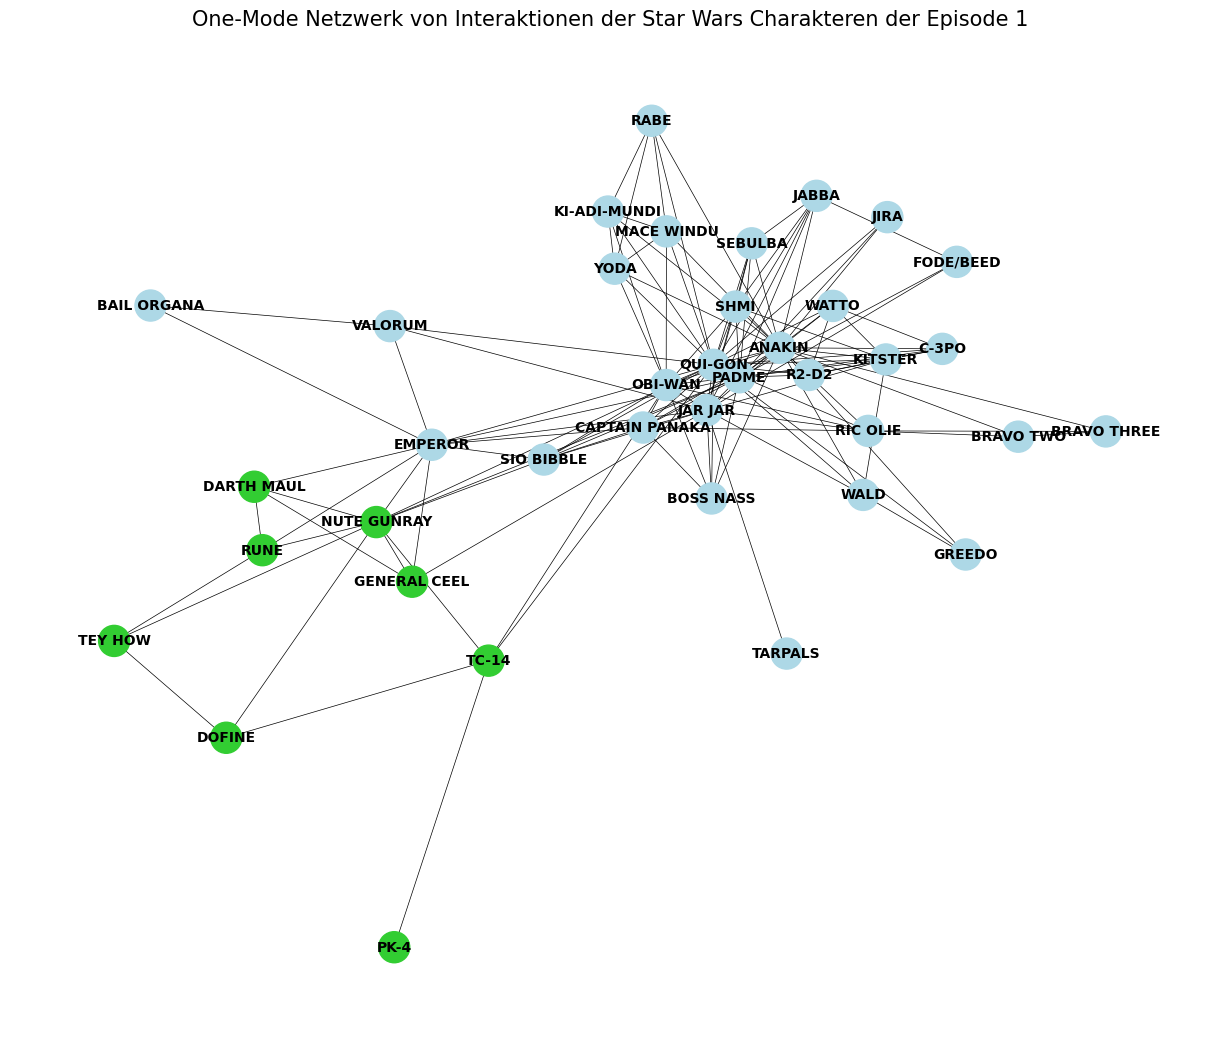

In [10]:
def get_node_groups_grivan_newman(graph, print_node_groups=False):
    labels = {node: data['label'] for node, data in graph.nodes(data=True)}
    communities = nx.community.girvan_newman(graph)
    node_groups = []
    for com in next(communities):
        node_groups.append(list(com))
    if print_node_groups:
        for i, group in enumerate(node_groups):
            print(f"Gruppe {i+1}:")
            for node in group:
                print(labels[node])
            print()
    return node_groups

node_first_groups = get_node_groups_grivan_newman(graph_first_episode, print_node_groups=False)

def create_color_map(graph, node_groups):
    color_map = []
    for node in graph:
        if node in node_groups[0]:
            color_map.append('Lightblue')
        else:
            color_map.append('Limegreen')
    
    return color_map

color_first_map = create_color_map(graph_first_episode, node_first_groups)

plot_episode_network(graph = graph_first_episode,
                        episode_number = 1,
                        node_colors = color_first_map)


Wie wir sehen, hat der Algorithmus zwei Cluster gebildet. Sie werden in unserer Darstellung oben farblich unterschieden. Es fällt auf, dass einige der Charaktere des kleineren Clusters zur «bösen Seite» gehören. Was allerdings auch wichtig zu sagen und nicht uninteressant ist, ist dass der Imperator (Emperor im Graph) nicht zu diesem «bösen» Cluster gehört, obwohl er ganz klar auch zu dieser Seite gehört. Der Grund dafür erklären wir uns dadurch, dass er viele Kanten zur «guten Seite» hat. Der Imperator ist in der ersten Episode einer der Hauptcharaktere und hat auch viele Interaktionen mit Personen der guten Seite, gerade in Konflikthandlungen. Der Algorithmus hat daher eher Nebencharaktere der «bösen Seite» zusammen gruppiert, diese agieren eher im Hintergrund und haben daher keine oder wenige Verbindungen zu Personen der «guten Seite».

## 3.2 Gibt es Cliquen?

Wir wollen untersuchen, ob es Cliquen innerhalb der ersten Episode vorhanden sind. Dabei verwenden wir die k-Core Clique Methode und untersuchen unterschiedliche k-Werte. Wir können somit Zentrale Charaktere die mit vielen anderen Charakteren im Film interagiert haben erkennen. NetworkX bietet hier die Funktion `nx.k_core` welche als Parameter einen NetworkX Graphen und k-Core Wert annimmt und als Rückgabewert einen Subgraphen mit den k-Core Nodes zurückgibt. Die Funktion `plot_k_core_network` nutzt die Funktion `nx.k_core` um einen Subgraphen zu erstellen und diesen anschliessend zu plotten. Die Funktion `plot_k_core_network` hat als Parameter den Graphen, die entsprechende Episode Folge und den k-Core Wert. Als weiteren Paramaeter haben wir `modus`, welche uns erlaubt zwischen die nicht zu den k-Core Nodes gehörenden Nodes zu verstecken oder nicht. `modus = just_k_core` versteckt die nicht zu den k-Core Nodes gehörenden Nodes und ansonsten versteckt die nicht zu den k-Core Nodes gehörenden Nodes nicht.

In unserem Fall testen wir die k-Core Werte 2, 4 und 6, ein Test mit höheren k-Werten ergab keine Clique, weil es keinen Charakter in der ersten Episode gab, der mit mehr als 6 anderen Charakteren interagiert hat.

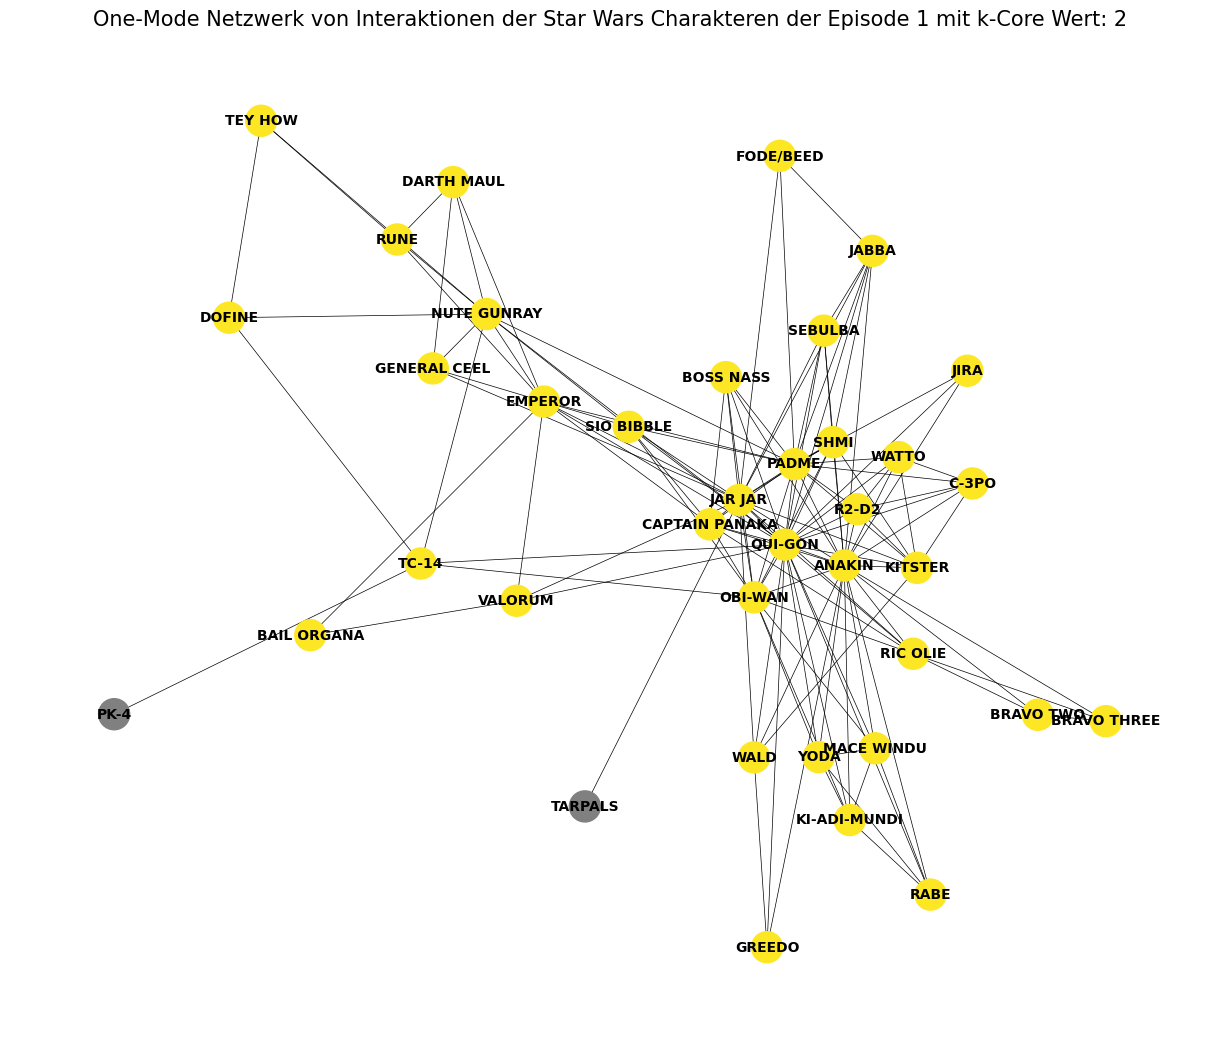

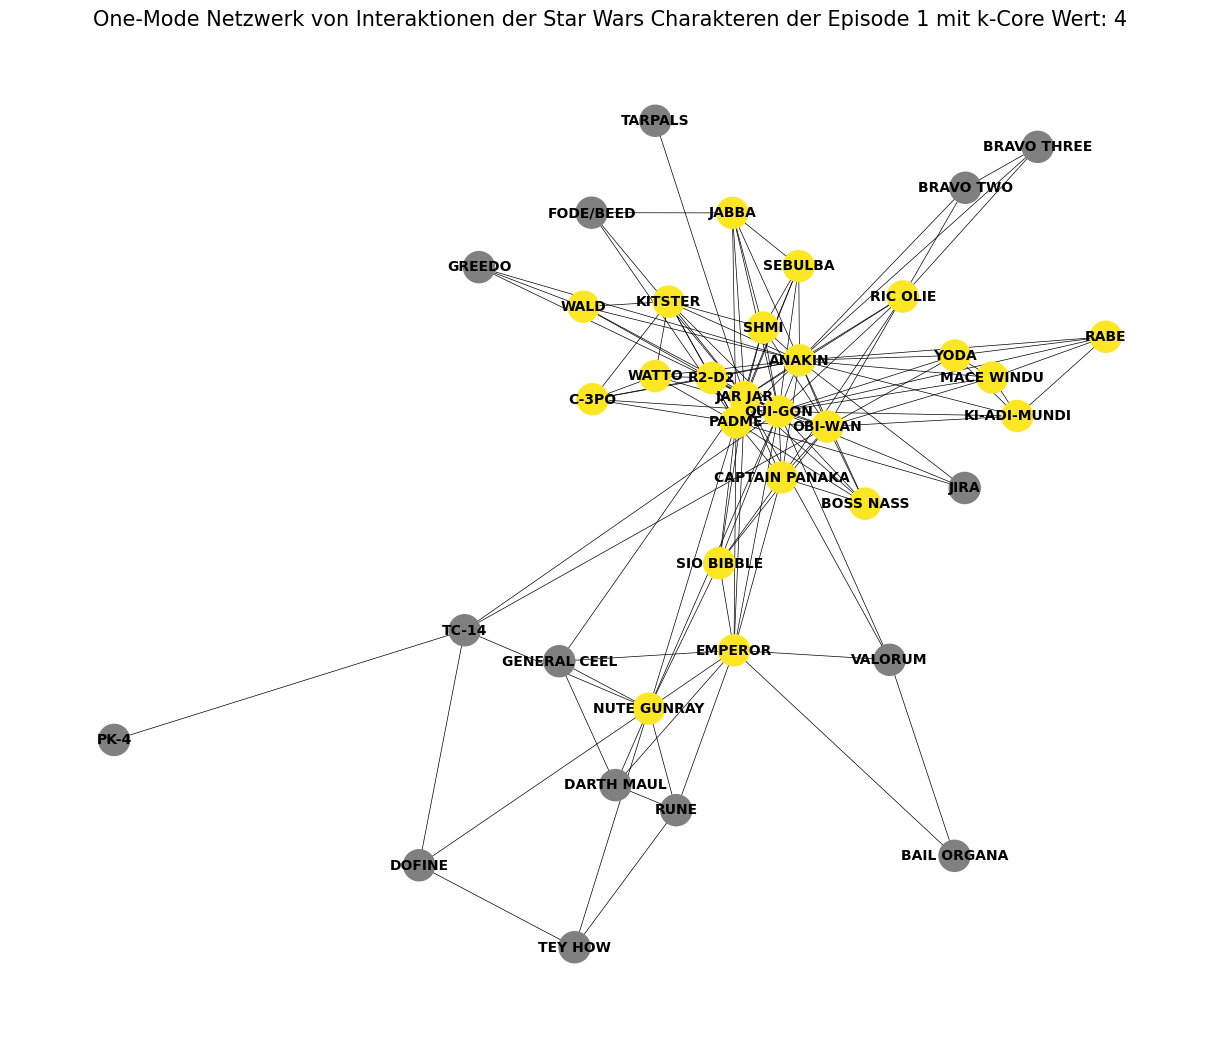

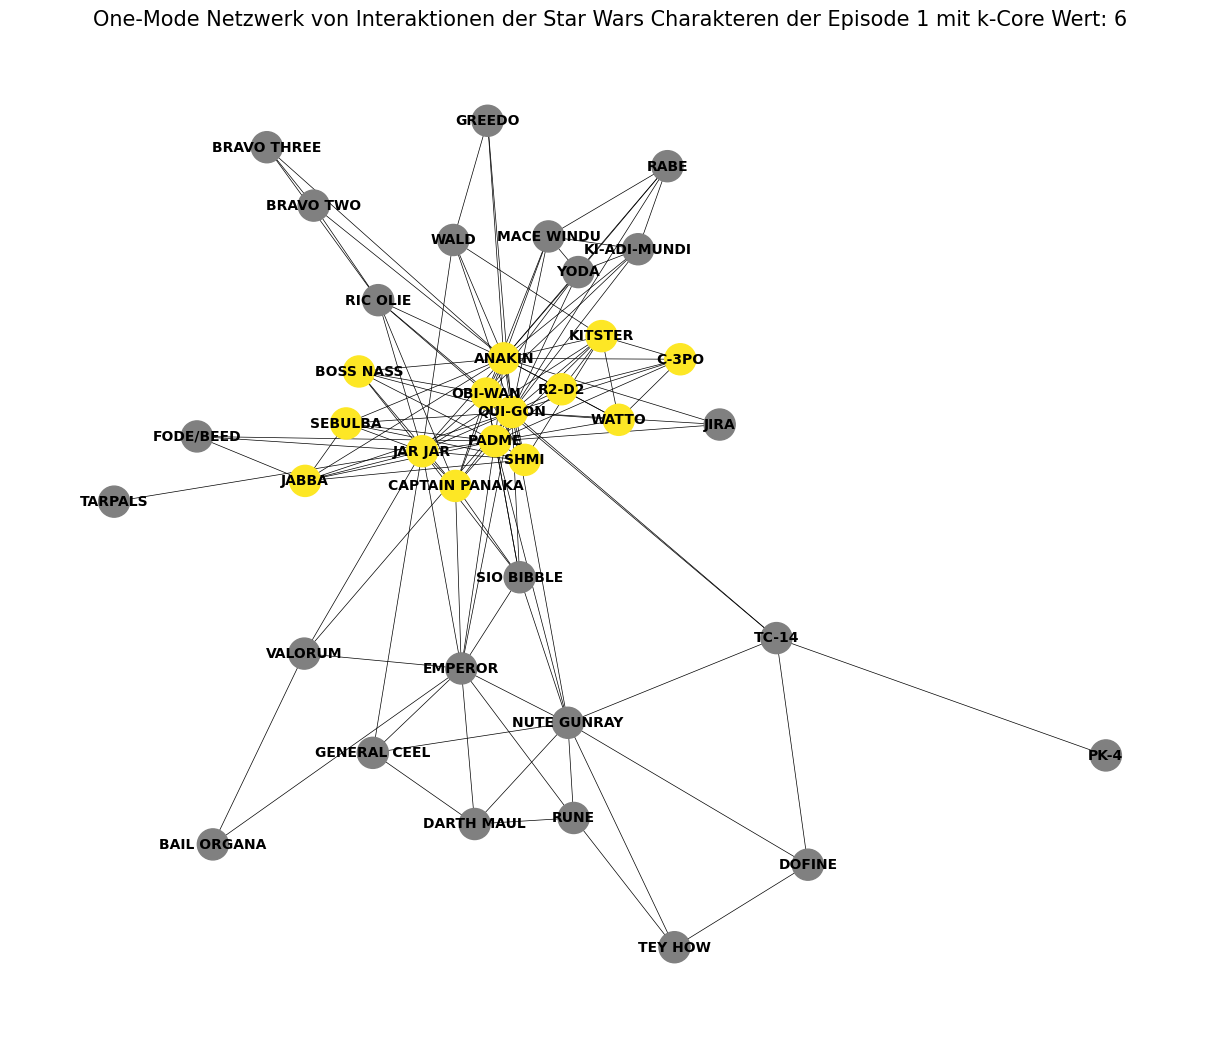

In [11]:
def plot_k_core_network(graph, episode_number, k_core_list, modus=None):
    # Define a colormap for assigning colors to k-core clusters
    cmap = plt.get_cmap("viridis")  

    if modus == "just_k_core":
        for k_value in k_core_list:
            k_core_cluster = nx.k_core(graph, k=k_value)
            labels = {node: data['label'] for node, data in k_core_cluster.nodes(data=True)}
            plt.figure(figsize=(12, 10))
            nx.draw(k_core_cluster, 
                    labels=labels, 
                    with_labels=True, 
                    node_size=500, 
                    node_color='Lightblue',
                    edge_color='black', 
                    font_size=10, 
                    font_weight='bold',
                    width=0.5)
            plt.title(f"One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode {episode_number} mit k-Core Wert: {k_value}", fontsize=15)
            plt.show()

    else:
        for k_value in k_core_list:
            k_core_cluster = nx.k_core(graph, k=k_value)
            labels = {node: data['label'] for node, data in k_core_cluster.nodes(data=True)}
            
            node_colors = {}
            k_core_colors = [cmap(i / k_value) for i in nx.core_number(k_core_cluster).values()]

            for node in k_core_cluster.nodes():
                node_colors[node] = k_core_colors.pop(0)

            for node in graph.nodes():
                if node not in node_colors:
                    node_colors[node] = 'gray'  
            
            plt.figure(figsize=(12, 10))
            labels = {node: data['label'] for node, data in graph.nodes(data=True)}
            node_colors_list = [node_colors[node] for node in graph.nodes()]
        
            nx.draw(
                graph,
                labels=labels,
                with_labels=True,
                node_size=500,
                node_color=node_colors_list,
                edge_color='black',
                font_size=10,
                font_weight='bold',
                width=0.5)

            plt.title(f"One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode {episode_number} mit k-Core Wert: {k_value}", fontsize=15)
            plt.show()

plot_k_core_network(graph=graph_first_episode, episode_number=1, k_core_list=[2, 4, 6])


 Wir erkennen in unseren Visualisierungen, dass der Graph weniger Nodes hat und beim k-Core 6 nur noch die Charaktere vorhanden sind, die mit mindestens 6 anderen Charakteren interagiert haben. Dies ist auch die Definition eines k-Cores, unser Code funktioniert also wie gewünscht.

Der k-Core Wert 6 ist der höchste Wert, für den eine Clique gefunden werde konnte. Sie ist im letzten Plot ersichtlich. Die Clique besteht zu etwa der Hälfte aus wichtigen Personen der Episode und gesamten Filmreihe: Anakin, Padme, Obi-Wan, Qui-Gon, R2-D2 und C-3PO. Da diese Charakteren viel Kontakt zueinander haben, ist es deshalb zu erwarten, dass sie eine enge Clique miteinander bilden.


## 3.3 Wie schnell würde sich die Geburt Yodas im Netzwerk verbreiten?

Da es bei Star Wars, wie der Name schon sagt, grösstenteils um Kriege geht, ist es wichtig zu wissen, wie schnell Informationen verbreitet werden. Eine Metrik, die dafür verwendet werden kann, ist der Diameter. Dabei handelt es sich um den längsten kürzesten Pfad im Netzwerk. Es handelt sich also um eine Entfernung und gibt an, wieviele Kanten maximal überwunden werden müssen.

In [12]:
print("Anzahl Kanten:", nx.diameter(graph_first_episode))

Anzahl Kanten: 4


Bei der ersten Episode beträgt der Diameter 4. Die Nachricht von zum Beispiel einer Geburt Yodas oder einem neuen Krieg, wird also nach spätestens vier Kanten alle Charaktere erreichen. Mangels Vergleichswerten kann die Anzahl nur schwer interpretiert werden, uns kommt sie aber relativ klein und effizient vor.

Eine Überprüfung der Kennzahl Diameter ist im originalen Netzwerk nicht gut möglich, da es recht unübersichtlich ist. Da wir gerade k-Core Clique erstellt haben, überprüfen wir die Metrik aber mit der Clique mit dem höchsten möglichen k-Wert (k=6).

In [13]:
print("Anzahl Kanten:", nx.diameter(nx.k_core(graph_first_episode, k=6)))

Anzahl Kanten: 2


Der Diameter beträgt 2. In dem Netzwerk konnten wir keine grösseren kürzesten Pfad feststellen. Auftreten tut der Wert relativ häufig, zum Beispiel zwischen den Charakteren Jabba-Kitster, Sebula-Anakin oder Qui-Gon-Watto.


# 4 Netzwerkanalyse der Entwicklungen im Verlauf der Episoden


Die Funktion `calculate_actor_centrality` berechnet verschiedene zentrale Kennzahlen (Centrality) für alle Charaketere in einem Graphen. 
Diese Kennzahlen helfen dabei, die Bedeutung oder Zentralität jeden Charaketer im Netzwerk zu quantifizieren.

Die Funktion nimmt als Parameter eine Liste von Graphen entgegen und gibt ein Dataframe zurück, welches die Charaktere und die entsprechenden Centrality Werte enthält. Dies ermöglicht es uns, die Entwicklung der Zentralität der Charaktere im Laufe der Episoden zu untersuchen und einfacher zu visualisieren sowie zu analysieren. 

Die Funktion ``plot_actor_metrics`` dient dazu, die Entwicklung der Zentralität von Charakteren im Verlauf der Episoden grafisch darzustellen. Als Parameter erwartet die Funktion das Dataframe, das aus der Funktion ``calculate_actor_centrality`` stammt, den Namen des Charakters, dessen Zentralitätsentwicklung wir visualisieren möchten, sowie den gewählten Visualisierungstyp.

Es stehen zwei Visualisierungstypen zur Auswahl: ein Liniendiagramm und ein Balkendiagramm. Die Interpretation der Visualisierung mittels eines Liniendiagramms ist oft einfacher, da die Entwicklung der Zentralität des Charakters im Laufe der Episoden besser erkennbar ist im Vergleich zum Balkendiagramm. Allerdings hat das Liniendiagramm den Nachteil, dass Charaktere, die am Anfang und am Ende einer Episode auftauchen, eine durchgehende Linie im Diagramm haben, was zu einer möglichen fehlerhaften Interpretation führen könnte. Einen Kompromiss gehen wir mit einem Scatterdiagramm ein indem wir die Punkte mit einer dashed Linie verbinden. Weiter um die INterpretierbarkeits fehler zu minimieren haben wir bewusst die Visualisierung interaktiv mittels Plotly umgesetzt. 

In [14]:
def calculate_actor_centrality(graph_every_episode):
    dfs = []
    for episode in graph_every_episode:
        # Calculate degree centrality
        degree_dict = nx.degree(episode)
        name_degree_list = [(episode.nodes[node]['label'], degree) for node, degree in degree_dict]
        df = pd.DataFrame(name_degree_list, columns=['Actor', 'Degree Centrality'])
        # calculate normalized degree centrality
        normalized_degree_dict = nx.degree_centrality(episode)
        name_normalized_degree_list = [(episode.nodes[node]['label'], normalized_degree) for node, normalized_degree in normalized_degree_dict.items()]
        df['Normalized Degree Centrality'] = [normalized_degree for actor, normalized_degree in name_normalized_degree_list]
        # Calculate closeness centrality
        closeness_dict = nx.closeness_centrality(episode)
        name_closeness_list = [(episode.nodes[node]['label'], closeness) for node, closeness in closeness_dict.items()]
        df['Closeness Centrality'] = [closeness for actor, closeness in name_closeness_list]
        # Calculate betweenness centrality
        betweenness_dict = nx.betweenness_centrality(episode)
        name_betweenness_list = [(episode.nodes[node]['label'], betweenness) for node, betweenness in betweenness_dict.items()]
        df['Betweenness Centrality'] = [betweenness for actor, betweenness in name_betweenness_list]
        # Calculate Clustering Coefficient
        clustering_dict = nx.clustering(episode)
        name_clustering_list = [(episode.nodes[node]['label'], clustering) for node, clustering in clustering_dict.items()]
        df['Clustering Coefficient'] = [clustering for actor, clustering in name_clustering_list]
        # Create a column with the episode number
        df['Episode'] = graph_every_episode.index(episode) + 1
        dfs.append(df)
    df_degree_centrality = pd.concat(dfs, ignore_index=True)
    return df_degree_centrality

actor_centrality_all = calculate_actor_centrality(graph_every_episode)
display(actor_centrality_all)

def plot_actor_metrics(dataframe, actors, metric_vis, plot_type="bar"):
    centrality_pick = dataframe[dataframe['Actor'].isin(actors)]
    if plot_type == "bar":
        fig = px.bar(centrality_pick, x="Episode", y=metric_vis, color="Actor", barmode="group")
    elif plot_type == "line":
        fig = px.line(centrality_pick, x="Episode", y=metric_vis, color="Actor")
    elif plot_type == "scatter":
        fig = px.scatter(centrality_pick, x="Episode", y=metric_vis, color="Actor")
        fig.update_traces(mode='lines+markers', marker=dict(size=10), line=dict(width=4, dash='dot'))
    else:
        raise ValueError("Invalid plot_type. Use 'bar' or 'line' or 'scatter'.")
    
    actors = centrality_pick['Actor'].unique()
    title = f'{metric_vis} for {", ".join(actors)}'
    fig.update_layout(title_text=title)
    fig.show()


,Actor,Degree Centrality,Normalized Degree Centrality,Closeness Centrality,Betweenness Centrality,Clustering Coefficient,Episode
0,R2-D2,6,0.162162,0.486842,0.000000,1.000000,1
1,QUI-GON,26,0.702703,0.770833,0.322614,0.255385,1
2,NUTE GUNRAY,10,0.270270,0.552239,0.125431,0.333333,1
3,PK-4,1,0.027027,0.336364,0.000000,0.000000,1
4,TC-14,5,0.135135,0.500000,0.073186,0.300000,1
...,...,...,...,...,...,...,...
181,YOLO ZIFF,4,0.153846,0.433333,0.000000,1.000000,7
182,COLONEL DATOO,1,0.038462,0.298851,0.000000,0.000000,7
183,ELLO ASTY,4,0.153846,0.433333,0.000000,1.000000,7
184,JESS,5,0.192308,0.440678,0.004615,0.700000,7


In [15]:
def get_names_of(datapath, interested_col="species", species="NaN", display_df = False):
    characters_data = pd.read_csv(datapath)
    if display_df:
        display(characters_data)
    characters_droid = characters_data[characters_data[interested_col] == species]
    characters_droid = characters_droid['name'].tolist()
    return characters_droid

characters_droid = get_names_of(datapath='data/Star Wars/characters.csv', interested_col="species", species="Droid", display_df = True)
print("Stawrwars Droiden Charaktere:", characters_droid)


,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,species
0,Luke Skywalker,172.0,77,blond,fair,blue,19BBY,male,Tatooine,Human
1,C-3PO,167.0,75,NaN,gold,yellow,112BBY,NaN,Tatooine,Droid
2,R2-D2,96.0,32,NaN,"white, blue",red,33BBY,NaN,Naboo,Droid
3,Darth Vader,202.0,136,none,white,yellow,41.9BBY,male,Tatooine,Human
4,Leia Organa,150.0,49,brown,light,brown,19BBY,female,Alderaan,Human
...,...,...,...,...,...,...,...,...,...,...
82,Rey,NaN,NaN,brown,light,hazel,NaN,female,NaN,Human
83,Poe Dameron,NaN,NaN,brown,light,brown,NaN,male,NaN,Human
84,BB8,NaN,NaN,none,none,black,NaN,none,NaN,Droid
85,Captain Phasma,NaN,NaN,NaN,NaN,NaN,NaN,female,NaN,NaN


Stawrwars Droiden Charaktere: ['C-3PO', 'R2-D2', 'R5-D4', 'IG-88', 'BB8']


Wie es scheint, kommen nur R2-D2 und C3PO in allen Episoden vor. Wir werden deshalb die Vergleiche anhand dieser beider Charakteren durchführen.

## 4.1 Wie entwickeln sich die Wichtigkeiten einzelner Charakteren/Gruppen im Verlauf der Filme?

### 4.1.1 Degree-Zentralität

In [16]:
plot_actor_metrics(actor_centrality_all, actors = characters_droid, metric_vis='Normalized Degree Centrality', plot_type='scatter')

### 4.1.2 Closeness Zentralität

In [17]:
plot_actor_metrics(actor_centrality_all, actors = characters_droid, metric_vis='Closeness Centrality', plot_type='scatter')

### 4.1.3 Betweenness Zentralität

In [18]:
plot_actor_metrics(actor_centrality_all, actors = characters_droid, metric_vis='Betweenness Centrality', plot_type='scatter')

In [19]:
plot_actor_metrics(actor_centrality_all, actors = characters_droid + ["PADME"], metric_vis='Betweenness Centrality', plot_type='scatter')

Gerne hätten wir auch die Prestige berechnet, da es sich bei unseren Netzwerken um ungerichtete handelt, ist dies leider nicht möglich.

# 5 Entwicklung der Film Netzwerke
## 5.1 Wie entwickeln sich die Zentralisierung der Netzwerke?

Metriken berechnen zu jedem Film und Visualisieren


 

## 5.1 Alle Netzwerke Visualisieren

Bevor wir mit den Berechnungen der Metriken anfangen, visualisieren wir alle Netzwerke, um uns einen Überblick zu verschaffen.

Die Funktion `plot_all_networks` nimmt als Parameter eine Liste von Graphen entgegen und visualisiert diese in einem Grid. Wir können somit mit dieser Funktion beliebige Episoden nebeneinander visualisieren. 

Durch die Visualisierung erkennen wir, dass die Anzahl an Charakteren unterschiedlich schwankt. Episode 5 weisst deutlich weniger Anzahl an Charakteren auf als bei Episode 1. Diese Erkentniss ist auch ebenfalls aus dem Kapitel 2, der explorativen Datenanalyse zu sehen. 

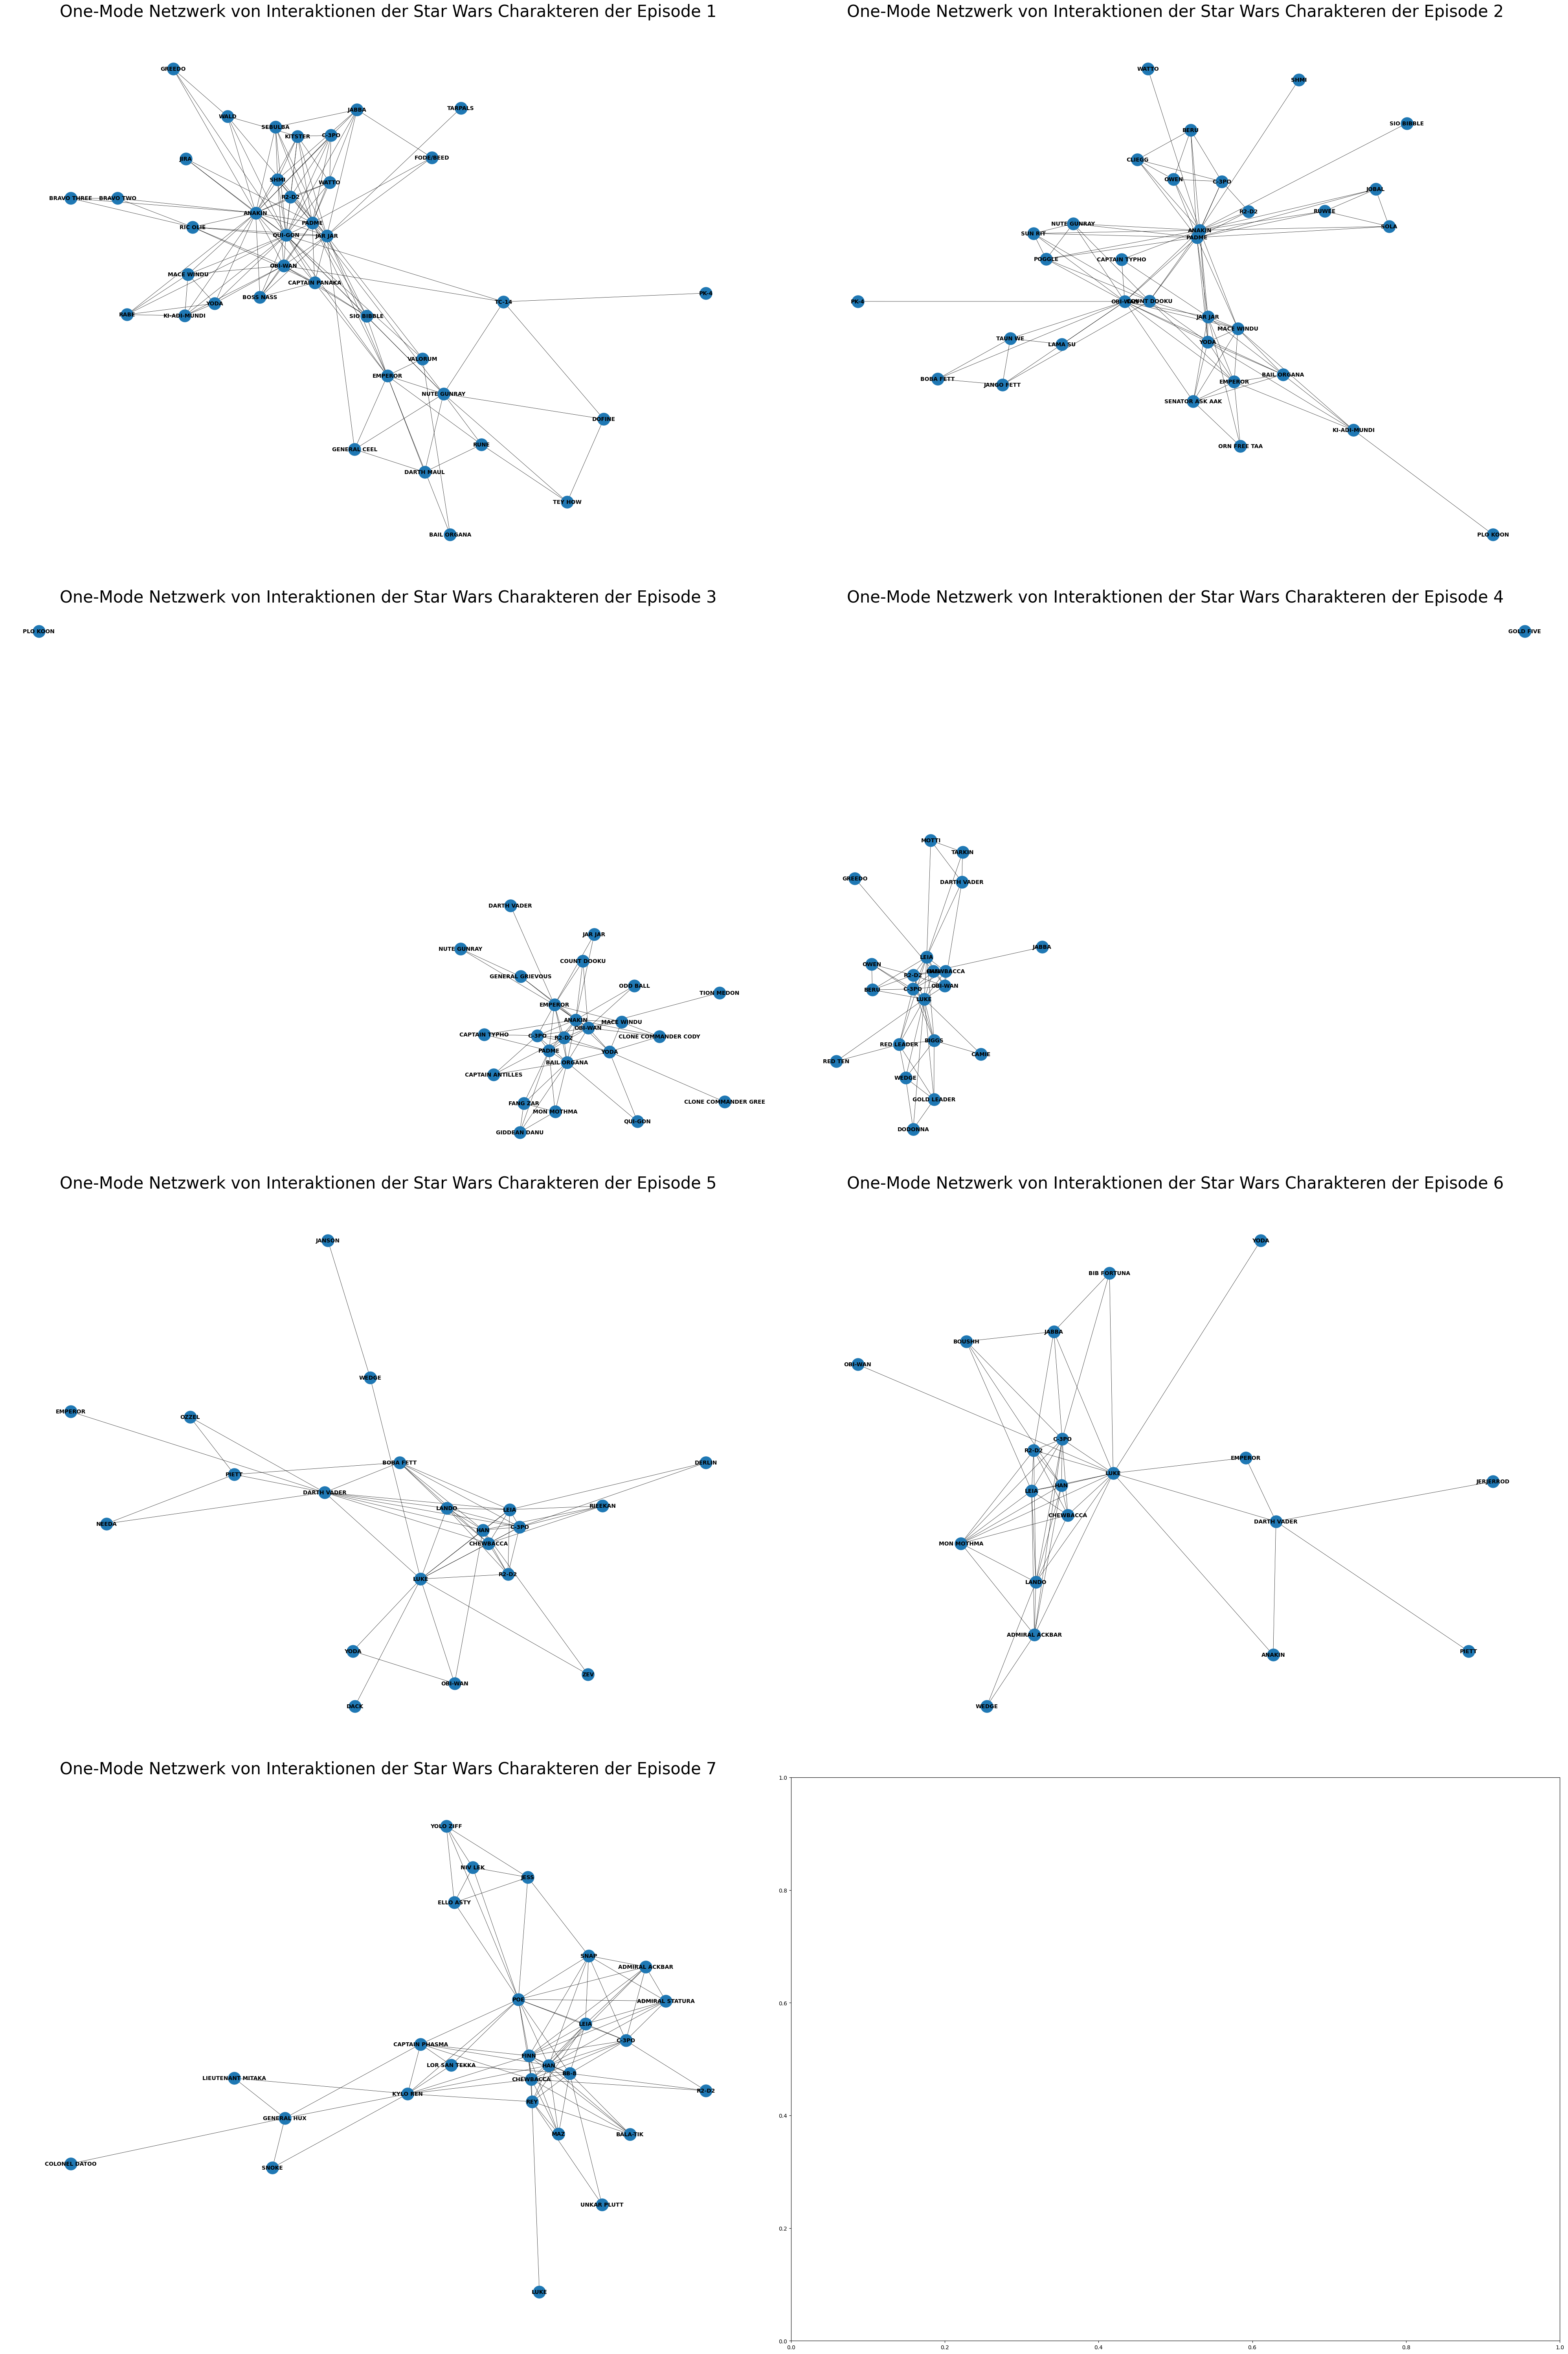

In [20]:
def plot_all_networks(episode_numbers, graph_data_list, figsize=(17, 7)):
    num_episodes = len(episode_numbers)
    num_columns = 2  

    num_rows = (num_episodes + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(figsize[0] * num_columns, figsize[1] * num_rows))

    for i, episode_number in enumerate(episode_numbers):
        if episode_number < 1 or episode_number > len(graph_data_list):
            print(f"Episode {episode_number} existiert nicht.")
            continue

        selected_graph = graph_data_list[episode_number - 1]

        labels = {node: data['label'] for node, data in selected_graph.nodes(data=True)}

        row = i // num_columns
        col = i % num_columns

        ax = axes[row, col] if num_rows > 1 else axes[col]
        plt.sca(ax)

        plt.title(f"One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode {episode_number}", fontsize=figsize[0] * 1.5)

        nx.draw(selected_graph,
                labels=labels,
                with_labels=True,
                node_size=500,
                edge_color='black',
                font_size=10,
                font_weight='bold',
                width=0.5)

    plt.tight_layout()
    plt.show()

plot_all_networks(episode_numbers = [1, 2, 3, 4, 5, 6, 7],
                 graph_data_list=graph_every_episode, figsize=(20, 15))

## 5.2 Verteilung der Actor Zenralitäten

Hier in diesem Abschnitt visualisieren wir die Verteilung der Aktor Zentralitäten. Die Funktion `plot_centrality_distribution` erlaubt es uns eine bestimmte Centrality Metrik zu visualisieren. Weiter wurde die Funktion so ausgebaut, dass man auch die gewünschte Episode auswählen kann. Die Funktion nimmt als Parameter das Dataframe, welches aus der Funktion `calculate_actor_centrality` stammt, die gewünschte Centrality Metrik, die gewünschte Episode.


In [21]:
def plot_centrality_distribution(df, metric_vis="Degree Centrality", alpha=0.5, episode_to_show=None):
    
    # filter for defined episode
    if episode_to_show is not None:
        df = df[df['Episode'].isin(episode_to_show)]
    
    fig = px.histogram(df, x=f"{metric_vis}", color="Episode", marginal="box", nbins=10, opacity=alpha)
    fig.update_layout(title_text=f"{metric_vis} Actor Verteilung", barmode="overlay")
    fig.show()

plot_centrality_distribution(actor_centrality_all, metric_vis="Degree Centrality", alpha=0.5)


## 5.2 Funktion für Berechnung der Netzwerk Metriken

Für die Berechnung der Metriken haben wir eine Classe geschrieben, welche uns erlaubt die Netzwerk Metriken für jeden Graphen zu berechnen. Die Classe `NetworkCentrality` wird dabei mit dem Dataframe `actor_centrality_all` aus Kapitel 4 Instanziert. In der Classe selbst gibt es eine Methode namens `calculate_network_centrality`, welche für jede Starwars Episoden Netzwerk die folgenden drei Netzwerkmetriekn, welche wir aus dem San Modul gelernt haben berechnet: Degree Network Centrality, Closeness Network Centrality und Betweenness Network Centraltity. Wir berechnen alle Netzwerk Metriken, damit wir diese anschliessend im späteren Kapitel visualiseren können, wie sich die Metriken im Verlauf der Episoden entwickeln haben.  
   
Als Reminder:  
"Die Netzwerk Zentralisierung kombiniert alle Aktor Zentralitäts-Werte zu einem einzelnen Wert, der
aussagt, wie gross die Ungleichheit der Aktor Zentralitäts-Werte innerhalb des Netzwerkes sind" (Soziale Netzwerkanalyse ©Michael Henninger Juli 2023, Version 3.7-beta).

Also anderst gesagt:   
Die Netzwerkzentralisierung ist ein Konzept in der Netzwerktheorie, das die Verteilung der Zentralitäts-Werte von Aktoren in einem Netzwerk bewertet. Diese Zentralitäts-Werte messen die Bedeutung oder Zentralität eines Aktors im Netzwerk, und es gibt verschiedene Messmethoden wie Degree Centrality, Closeness Centrality und Betweenness-Centrality. Die Netzwerkzentralisierung fasst diese Werte zusammen, um die Ungleichheit der Zentralitäts-Werte im Netzwerk zu quantifizieren. Hohe Netzwerkzentralisierung bedeutet, dass wenige Aktoren eine hohe Zentralität haben und die meisten eine niedrigere Zentralität aufweisen. Niedrige Netzwerkzentralisierung zeigt an, dass die Zentralitäts-Werte gleichmässiger verteilt sind, was auf eine gleichmässigere Verteilung von Macht oder Einfluss im Netzwerk hinweisen kann.


In [22]:
class NetworkCentrality():
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.actors = self.dataframe['Actor'].unique()
        self.episodes = self.dataframe['Episode'].unique()

    # calculate n for each episode
    def _n_actor_for_episode(self, episode):
        return len(self.dataframe[self.dataframe['Episode'] == episode]['Actor'].unique())
    
    # get maximum value of centrality for each episode
    def _max_centrality_for_episode(self, episode, centrality):
        return self.dataframe[self.dataframe['Episode'] == episode][centrality].max()
    
    # get degree centrality for each episode
    def _degree_centrality(self, episode):
        return self.dataframe[self.dataframe['Episode'] == episode]['Degree Centrality']
    
    # get closeness centrality for each episode
    def _closeness_centrality(self, episode):
        return self.dataframe[self.dataframe['Episode'] == episode]['Closeness Centrality']
    
    # get betweenness centrality for each episode
    def _betweenness_centrality(self, episode):
        return self.dataframe[self.dataframe['Episode'] == episode]['Betweenness Centrality']
    
    # calculate Degree Network Centrality 
    def degree_network_centrality(self, episode):
        """
        implementation based on san script michael henninger
        """
        c_max = self._max_centrality_for_episode(episode, 'Degree Centrality')
        c = self._degree_centrality(episode)
        n = self._n_actor_for_episode(episode)
        return (np.sum(c_max - c)) / ((n - 1) * (n - 2))
    
    # calculate Closeness Network Centrality
    def closeness_network_centrality(self, episode):
        """
        implementation based on san script michael henninger,
        closnes centrality must be normalized!
        """
        c_max = self._max_centrality_for_episode(episode, 'Closeness Centrality')
        c = self._closeness_centrality(episode)
        n = self._n_actor_for_episode(episode)
        return (np.sum(c_max - c)) / ((n - 2) / 2)
    
    # calculate Betweenness Network Centrality
    def betweenness_network_centrality(self, episode):
        """
        implementation based on san script michael henninger
        Betweenness centrality must be normalized!
        """
        c_max = self._max_centrality_for_episode(episode, 'Betweenness Centrality')
        c = self._betweenness_centrality(episode)
        n = self._n_actor_for_episode(episode)
        return (np.sum(c_max - c)) / (n - 1)
    
    def calculate_network_centrality(self):
        """
        implementation based on san script michael henninger
        """
        dfs = []
        for episode in self.episodes:
            df_episode = pd.DataFrame({'Episode': [episode],
                                    'Degree Network Centrality': [self.degree_network_centrality(episode)],
                                    'Closeness Network Centrality': [self.closeness_network_centrality(episode)],
                                    'Betweenness Network Centrality': [self.betweenness_network_centrality(episode)]})
            dfs.append(df_episode)
        
        df = pd.concat(dfs, ignore_index=True)
        return df
    
    # visualize network centrality
    def plot_network_centrality(self, plot_type="bar", centrality_to_show=["Degree Network Centrality", "Closeness Network Centrality", "Betweenness Network Centrality"]):
        df = self.calculate_network_centrality()
        centrality_to_show = centrality_to_show
        if plot_type == "bar":
            fig = px.bar(df, x="Episode", y=centrality_to_show, barmode="group", title=f"Network Centrality for {', '.join(centrality_to_show)}")
        elif plot_type == "line":
            fig = px.line(df, x="Episode", y=centrality_to_show)
        elif plot_type == "scatter":
            fig = px.scatter(df, x="Episode", y=centrality_to_show)
            fig = fig.update_traces(mode='lines+markers')
        else:
            raise ValueError("Invalid plot_type. Use 'bar' or 'line' or 'scatter'.")
        
        title = f'Network Centrality for: {", ".join(centrality_to_show)}'
        fig.update_layout(title_text=title)
        fig.show()
        
        
        

## 5.2.1 Initialisierung der Klasse

Hier in diesem Abschnitt instanzieren wir die Klasse mit dem Dataframe `actor_centrality_all` aus Kapitel 4 und wenden die Methode `calculate_network_centrality` an. Die Methode berechnet die Netzwerk Metriken für jede Episode und speichert diese in einem Dataframe ab. Dis tun wir wir, weil wir mit dem Dataframe später einfacher die Metriken analysieren und visualisieren können.

In [23]:
# Initliaze NetworkCentrality class
network_centrality = NetworkCentrality(actor_centrality_all)

# calculate network centrality for each episode
network_centrality_df = network_centrality.calculate_network_centrality()
display(network_centrality_df)

,Episode,Degree Network Centrality,Closeness Network Centrality,Betweenness Network Centrality
0,1,0.539039,0.594011,0.299801
1,2,0.494960,0.519780,0.357497
2,3,0.398551,0.475134,0.151207
3,4,0.500000,0.593563,0.294207
4,5,0.373684,0.455374,0.378344
5,6,0.555556,0.646740,0.572894
6,7,0.381538,0.399375,0.265644


### 5.2.2 Degree Zentralisierung 

Aus dem San Skirpt kennen wir die Formel für die Berechnung der Degree Zentralisierung auf ungerichtet Graphen.   
Die Formel lautet wie folgt:

\begin{align*}
Ungerichteter Graph  => CD = \frac{\sum_{i=1}^{n}  C'D(p^*) - C'D(p_i)}{(n-1)(n-2)} 
\end{align*}

Bei einem Gerichteten Graphen fällt im Nenner der Term $(n-2)$ weg.

Hier in diesem Degree Zentralisierung von unserem Starwars Episoden Netzwerk erkennen wir, dass sich der Wertebreich sich zwischen 0.38 und 0.56 bewegt. Wir erkennen auch, dass in der Episode 5 der tiefste Degree Zentralisierungs und in der Episode 6 der höchste Wert vorhanden ist. Wir können somit interpretieren, dass in der Episode 5 die Actor Degree Zentrailität Charaktere gleichmässiger bzw besser verteilt sind und in der Episode 6 die Actor Degree Zentralität ungleichmässiger verteilt sind. Anderst gesagt bedeutet dass, dass es einen Zentraleren wichtigeren Charakter in der 6. Folge exisitert. Generell können wir jedoch sagen, dass sich die Netzwerk Zentralisierung im Verlaufe der Episoden sich nur minimal voneinander unterscheiden. Wir können diese Aussage untermauern, indem wir die Actor Zentralitätswert für die Episode 5 und 6 vergleichen. Wir erkennen im Verteilungsplot, dass in der Episode 6 es einen Charakter gibt, der eine sehr hohe Normalizierte Degree Centrality Wert aufweist und während in der Episode 5, die Charaktere gleichmässiger verteilt sind. Nun können wir mittels einem einfachen Filter Statement herausfinden, welcher Charakter nun zuständig ist für den hohen Degree Network Centrality Wert, indem wir den höchsten Wert aus dem Dataframe `actor_centrality_all` herausfiltern. Es ist der Charakter `LUKE` der im Film 6 eine der Zentralsten Rolle spielt.

In [24]:
# visualize Degree Network Centrality for each episode
network_centrality.plot_network_centrality(plot_type="line", centrality_to_show=["Degree Network Centrality"])

In [25]:
# plot centrality distribution for episode 5 and 6
plot_centrality_distribution(actor_centrality_all, metric_vis="Normalized Degree Centrality", episode_to_show=[5, 6], alpha=0.5)

In [26]:
# Filter for highest normalized degree centrality for episode 6
actor_centrality_all[actor_centrality_all['Episode'] == 6].sort_values(by='Normalized Degree Centrality', ascending=False).head(1)

,Actor,Degree Centrality,Normalized Degree Centrality,Closeness Centrality,Betweenness Centrality,Clustering Coefficient,Episode
146,LUKE,15,0.789474,0.826087,0.596881,0.304762,6


### 5.2.3 Closeness Zentralisierung

Aus dem San Skirpt kennen wir die Formel für die Berechnung der Closeness Zentralisierung auf ungerichtet Graphen.

\begin{align*}
CC &= \frac{1}{n} \sum_{i=1}^{n} \left[ \frac{C'(p^*) - C'(p_i)}{n-2} \right] \\
\end{align*}

Hier in dieser Visualisierung sehen wir die Closeness Zentralisierung von unserem Starwars Episoden Netzwerk. Wir sehen, dass sich der Wert in diesen ersten drei Episoden kontuierlich sinkt, dass bedeutet, dass die Closeness Werte für die Charaktere in diesen Episoden sich immer mehr annähern. In der Episode 4 steigt der Wert wieder an und sinkt aber jedoch in der darauffolgenden 5 Episode. In der 6 Episoden steigt diese dann zum maximalen Wert 0.65 an, dies bedeutet, dass in dieser Episode 6, die Aktor Closeness Centrality Werte sich am meisten voneinander unterscheiden. In der letzten Epsiode 7, sinkt der Wert auf den tiefsten Closeeness Zentralisierung Wert 0.4.

In [27]:
# visualize Closeness Network Centrality for each episode
network_centrality.plot_network_centrality(plot_type="line", centrality_to_show=["Closeness Network Centrality"])

In [28]:
# plot centrality distribution for episode 6 and 7
plot_centrality_distribution(actor_centrality_all, metric_vis="Closeness Centrality", episode_to_show=[6, 7])

In [29]:
# Filter for highest closeness centrality for episode 6
actor_centrality_all[actor_centrality_all['Episode'] == 6].sort_values(by='Closeness Centrality', ascending=False).head(1)

,Actor,Degree Centrality,Normalized Degree Centrality,Closeness Centrality,Betweenness Centrality,Clustering Coefficient,Episode
146,LUKE,15,0.789474,0.826087,0.596881,0.304762,6


### 5.2.3 Betweenness Zentralisierung 

Aus dem San Skirpt kennen wir die Formel für die Berechnung der Betweenness Zentralisierung.

\begin{align*}
C\small{B} = \frac{\sum_{i=1}^{n} C'\small{B}(p^*) - C'\small{B}(p_i)}{(n-1)}
\end{align*}


Hier ist der Verlauf verglichen zu den vorherhigen Netzwerk Zentralitäts Metriken ab der 3. Episode bis zur 6. Episode interessant. Vom tiefesten Beteeweenness Zentralisierung Wert 0.15 in der 3. Episode steigt diese kontiuerlich weiter an bis zur 6. Episode und erreicht seinen höchsten Wert mit einem Peak von 0.57. Ein tiefer Wert bedeutet, dass die Actor Betweenness Centrality Werte sich ähnlicher sind und ein hoher Wert bedeutet, dass die Actor Betweenness Centrality Werte sich stark voneinander unterscheiden. Wir könnten somit interpretieren, dass in der 6. Episode die Actor Betweenness Centrality Werte sich am meisten voneinander unterscheiden und wenige wichtigere Charaktere Schlüsselpositionen im Netzwerk einnehmen, während dies in der 3. Episode nicht der Fall war.

In [30]:
# visualize Betweenness Network Centrality for each episode
network_centrality.plot_network_centrality(plot_type="line", centrality_to_show=["Betweenness Network Centrality"])

In [31]:
# plot centrality distribution for episode 6 and 7
plot_centrality_distribution(actor_centrality_all, metric_vis="Betweenness Centrality", episode_to_show=[3, 6])

In [32]:
# Filter for highest betweenness centrality for episode 6
actor_centrality_all[actor_centrality_all['Episode'] == 6].sort_values(by='Betweenness Centrality', ascending=False).head(1)

,Actor,Degree Centrality,Normalized Degree Centrality,Closeness Centrality,Betweenness Centrality,Clustering Coefficient,Episode
146,LUKE,15,0.789474,0.826087,0.596881,0.304762,6


## 5.3 Alle Netzwerk Zentralisierungs Metriken für alle Episoden

Vollständigkeitshalber visualisieren wir alle drei Netzwerk Metriken für alle Episoden, farblich voneinander getrennt. Wir erkennen, dass sich die Netzwerk Metriken von Degree und Closeness einen ähnlichen Verlauf haben, während die Betweenness Zentralisierung sich von den beiden anderen Metriken unterscheidet. Jedoch sehr interessant ist die 6. Episode, denn in dieser Episode haben alle Netzwerke den maximalen höchsten Netzwerk Zentralitäts Wert. 

In [33]:
# visualize all network centrality metrics for each episode
network_centrality.plot_network_centrality(plot_type="line", centrality_to_show=["Degree Network Centrality", "Closeness Network Centrality", "Betweenness Network Centrality"])

## 5.2 Netzwerk Metriken





### 5.2.1 Graph Density

Dokuementation von Graph Density in NetworkX: https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html

In [34]:
def calculate_graph_density(graph_every_episode):
    dfs = []
    for G_episode in graph_every_episode:
        density = nx.density(G_episode)
        dfs.append(density)
    df_density = pd.DataFrame(dfs, columns=['Density'])
    df_density = df_density.reset_index(drop=False).rename(columns={"index": "Episode"})
    df_density['Episode'] = df_density['Episode'] + 1
    return df_density

df_density = calculate_graph_density(graph_every_episode)
display(df_density)

fig = px.line(df_density, x="Episode", y="Density")
fig.update_layout(title_text="Dichte der Star Wars Episode Netzwerke")
fig.show()


,Episode,Density
0,1,0.192034
1,2,0.191288
2,3,0.216667
3,4,0.259740
4,5,0.261905
5,6,0.289474
6,7,0.262108


### 5.2.2 Cluster Coefficient einzelner Nodes


In [35]:
display("Cluster Coefficient for each node:", actor_centrality_all[["Actor", "Episode", "Clustering Coefficient"]])

'Cluster Coefficient for each node:'

,Actor,Episode,Clustering Coefficient
0,R2-D2,1,1.000000
1,QUI-GON,1,0.255385
2,NUTE GUNRAY,1,0.333333
3,PK-4,1,0.000000
4,TC-14,1,0.300000
...,...,...,...
181,YOLO ZIFF,7,1.000000
182,COLONEL DATOO,7,0.000000
183,ELLO ASTY,7,1.000000
184,JESS,7,0.700000


In [36]:
plot_actor_metrics(actor_centrality_all, actors = ['R2-D2', 'C-3PO'], metric_vis='Clustering Coefficient', plot_type='line')

### 5.2.3 Cluster Coefficient der Netzwerke 

In [37]:
def average_clustering_coefficient(graph_every_episode):
    dfs = []
    for G_episode in graph_every_episode:
        avg_clustering_coefficient = nx.average_clustering(G_episode)
        dfs.append(avg_clustering_coefficient)
    df_avg_clustering_coefficient = pd.DataFrame(dfs, columns=['Clustering Coefficient'])
    df_avg_clustering_coefficient = df_avg_clustering_coefficient.reset_index(drop=False).rename(columns={"index": "Episode"})
    df_avg_clustering_coefficient['Episode'] = df_avg_clustering_coefficient['Episode'] + 1
    return df_avg_clustering_coefficient

df_avg_clustering_coefficient = average_clustering_coefficient(graph_every_episode)
display("Average Cluster Coefficient for each Episode:", df_avg_clustering_coefficient)

fig = px.line(df_avg_clustering_coefficient, x="Episode", y="Clustering Coefficient")
fig.update_layout(title_text="Durchschnittlicher Clustering Coefficient der Star Wars Episode Netzwerke")
fig.show()


'Average Cluster Coefficient for each Episode:'

,Episode,Clustering Coefficient
0,1,0.711575
1,2,0.677909
2,3,0.599564
3,4,0.663872
4,5,0.628582
5,6,0.609444
6,7,0.701772


# 6 Link-Prediction

Bei der Link Prediction wird versucht vorherzusagen, welche Charakteren eine direkte Verbindung (also Kante) aufbauen sollten.

Für die Link Predictions verwenden wir die drei Methoden Jaccard Coefficient, Preferential Attachment und Resource Allocation. Wir haben sie ausgewählt, weil sie einerseits unterschiedliche Berechnungsmethoden haben und andererseits, weil sie komplexer als z.B. die Common Neighbours Methode sind.

Aufgrund der unterschiedlichen Berechnungsmethoden wird es interessant sein, zu sehen, wie unterschiedlich die Link Predictions sind. Zusätzlich werden wir einzelne Predictions genauer anschauen und so weit möglich die Berechnung von Networkx überprüfen.

Zum Schluss werden wir auch eine Methode für eine mögliche Anwendung bestimmen.

In [38]:
lst_prediction_methods = ["jaccard_coefficient", "preferential_attachment", "resource_allocation_index"]
lst_predictions = []

for method in lst_prediction_methods:
    method = getattr(nx, method)
    predictions = method(graph_first_episode)
    lst_predictions.append(list(predictions))

labels = {node: data['label'] for node, data in graph_first_episode.nodes(data=True)}

for method_name, method_predictions in zip(lst_prediction_methods, lst_predictions):
    sorted_link_pred = sorted(method_predictions, key=lambda x: x[2], reverse=True)
    top_5_recommendations = sorted_link_pred[:5]

    top_5_recommendations_names = [(labels[u], labels[v], p) for u, v, p in top_5_recommendations]

    print(f"Top 5 Empfehlungen mit {method_name}:")
    for u, v, p in top_5_recommendations_names:
        print(u, "und", v, "Wert:", round(p, 3))
    print()


Top 5 Empfehlungen mit jaccard_coefficient:
SIO BIBBLE und BOSS NASS Wert: 0.625
BOSS NASS und RIC OLIE Wert: 0.625
RUNE und GENERAL CEEL Wert: 0.6
BOSS NASS und SHMI Wert: 0.556
R2-D2 und JIRA Wert: 0.5

Top 5 Empfehlungen mit preferential_attachment:
EMPEROR und ANAKIN Wert: 253
NUTE GUNRAY und ANAKIN Wert: 230
NUTE GUNRAY und JAR JAR Wert: 180
SIO BIBBLE und ANAKIN Wert: 161
OBI-WAN und EMPEROR Wert: 143

Top 5 Empfehlungen mit resource_allocation_index:
OBI-WAN und RABE Wert: 0.582
NUTE GUNRAY und JAR JAR Wert: 0.578
RUNE und GENERAL CEEL Wert: 0.441
NUTE GUNRAY und OBI-WAN Wert: 0.437
TC-14 und TEY HOW Wert: 0.433



Für jede der drei Methoden wurden die Top fünf Empfehlungen angezeigt. Wir stellen fest, dass die Methoden recht unterschiedliche Resultate generiert haben. Zwar kommen häufig ähnliche Charakteren vor, doch meistens in anderen Kombinationen. Die Wahl der Methode hat also einen wichtigen Einfluss auf die erstellten Predictions.

Folgend werden wir die Top-Empfehlungen der einzelnen Methoden genauer anschauen.

In [39]:
def top_n_characters(lst_prediction_methods, lst_predictions, index, n_characters, top_n_pred):
    method_name = lst_prediction_methods[index]
    method_predictions = lst_predictions[index]

    sorted_link_pred = sorted(method_predictions, key=lambda x: x[2], reverse=True)
    top_n_recommendations = sorted_link_pred[:top_n_pred]

    char_counter = Counter()
    for u, v, _ in top_n_recommendations:
        char_counter[labels[u]] += 1
        char_counter[labels[v]] += 1

    top_n_chars = char_counter.most_common(n_characters)

    print(f"Top {n_characters} am häufigsten empfohlene Charaktere in den Top {top_n_pred} Empfehlungen mit {method_name}:")
    for char, count in top_n_chars:
        print(f"{char}: {count} Mal")

#### 6.1 Jaccard Coefficient

In [40]:
top_n_characters(lst_prediction_methods, lst_predictions, 0, 7, 30)

print()
print("Untersuchung einzelner Top Predictions:")

print()
print("Anzahl Nachbarn von Sio Bibble:", nx.degree(graph_first_episode, 11), "und von Boss Nass:", nx.degree(graph_first_episode, 14))
print("Nachbarn von Sio Bibble:", sorted(graph_first_episode.neighbors(11)))
print("Nachbarn von Boss Nass:", sorted(graph_first_episode.neighbors(14)))
print("Anzahl gemeinsamer Nachbarn:", len(sorted(nx.common_neighbors(graph_first_episode, 11, 14))))

print()
print("Anzahl Nachbarn von R2-D2:", nx.degree(graph_first_episode, 0), "und von Jira:", nx.degree(graph_first_episode, 20))
print("Nachbarn von R2-D2:", sorted(graph_first_episode.neighbors(0)))
print("Nachbarn von Jira:", sorted(graph_first_episode.neighbors(20)))
print("Anzahl gemeinsamer Nachbarn:", len(sorted(nx.common_neighbors(graph_first_episode, 0, 20))))

Top 7 am häufigsten empfohlene Charaktere in den Top 30 Empfehlungen mit jaccard_coefficient:
BOSS NASS: 7 Mal
JIRA: 7 Mal
SHMI: 6 Mal
SIO BIBBLE: 4 Mal
SEBULBA: 4 Mal
WALD: 4 Mal
R2-D2: 3 Mal

Untersuchung einzelner Top Predictions:

Anzahl Nachbarn von Sio Bibble: 7 und von Boss Nass: 6
Nachbarn von Sio Bibble: [1, 2, 5, 9, 10, 12, 15]
Nachbarn von Boss Nass: [1, 5, 10, 12, 15, 18]
Anzahl gemeinsamer Nachbarn: 5

Anzahl Nachbarn von R2-D2: 6 und von Jira: 3
Nachbarn von R2-D2: [1, 15, 17, 18, 22, 24]
Nachbarn von Jira: [1, 15, 18]
Anzahl gemeinsamer Nachbarn: 3


Boss Nass und Jira werden mit je sieben Nennungen am häufigsten in den Top 30 Empfehlungen genannt. Wie wir bereits früher festgestellt haben, sind das Charakteren mit eher weniger Nachbarn. Entsprechend ist es vermutlich wahrscheinlicher, dass sie mit anderen Charakteren starke Übereinstimmungen der Nachbarn haben, was einen höheren Koeffizienten ergibt.

Bei der Analyse der ersten Prediction (Sio Bibble und Boss Nass) stellen wir fest, dass sie sieben und sechs Nachbarn haben, fünf davon sind gemeinsam. Dividieren wir diesen Wert durch acht, der Anzahl unterschiedlicher Nachbarn des Paars, erhalten wir den Koeffizient 0.625. Diesen Wert hat auch Networkx berechnet.

Bei der fünften Empfehlung (R2-D2 und Jira) gibt es nur drei gemeinsame Nachbarn, die sechs unterschiedlicher Nachbarn gegenüber stehen. Entsprechend ist der Koeffizient mit 0.5 tiefer.

## 6.2 Preferential Attachment

In [41]:
top_n_characters(lst_prediction_methods, lst_predictions, 1, 7, 30)

print()
print("Untersuchung einzelner Top Predictions:")
print()
print("Anzahl Nachbarn von Emperor:", nx.degree(graph_first_episode, 9), "und von Anakin:", nx.degree(graph_first_episode, 18))
print("Multiplikation der Anzahl Nachbarn:", nx.degree(graph_first_episode, 9) * nx.degree(graph_first_episode, 18))
print()
print("Anzahl Nachbarn von Obi-Wan:", nx.degree(graph_first_episode, 5), "und von Emperor:", nx.degree(graph_first_episode, 9))
print("Multiplikation der Anzahl Nachbarn:", nx.degree(graph_first_episode, 5) * nx.degree(graph_first_episode, 9))

Top 7 am häufigsten empfohlene Charaktere in den Top 30 Empfehlungen mit preferential_attachment:
ANAKIN: 8 Mal
JAR JAR: 8 Mal
NUTE GUNRAY: 5 Mal
OBI-WAN: 4 Mal
PADME: 4 Mal
EMPEROR: 3 Mal
KITSTER: 3 Mal

Untersuchung einzelner Top Predictions:

Anzahl Nachbarn von Emperor: 11 und von Anakin: 23
Multiplikation der Anzahl Nachbarn: 253

Anzahl Nachbarn von Obi-Wan: 13 und von Emperor: 11
Multiplikation der Anzahl Nachbarn: 143


Anakin und Jar Jar werden mit je acht Nennungen am häufigsten in den Top 30 Empfehlungen genannt. Das sind beides Charakteren mit einer relativ hohen Anzahl Nachbarn. Aufgrund der Berechnungsweise der Methode ist es zu erwarten, dass solche Charakteren häufig empfohlen werden. Denn mögliche Predictions mit ihnen bekommen schneller einen hohen Koeffizienten.

Die Analyse der Top Empfehlung (Emperor und Anakin) zeigt, dass das vorgeschlagene Paar 13 und 23 Nachbarn hat. Multipliziert ergibt das einen Wert von 253, was auch Networkx berechnet hat. Bei der fünften Empfehlung (Obi-Wan und Emperor) beträgt der Koeffizient bereits nur noch 143.

## 6.3 Resource Allocation

In [42]:
top_n_characters(lst_prediction_methods, lst_predictions, 2, 7, 30)

print()
print("Untersuchung einzelner Top Predictions:")
print()
print("Gemeinsame Nachbarn von Obi-Wan und Rabe:")
print(sorted(nx.common_neighbors(graph_first_episode, 5, 33)))
print("Anzahl der Nachbarn dieser Nachbarn:", graph_first_episode.degree(sorted(nx.common_neighbors(graph_first_episode, 5, 33))))
print("Inverse dieser Anzahl:", [round(1 / graph_first_episode.degree(neighbor), 5) for neighbor in sorted(nx.common_neighbors(graph_first_episode, 5, 33)) if graph_first_episode.degree(neighbor) > 0])
print("Summe der Inversen:", round(sum(1 / graph_first_episode.degree(neighbor) for neighbor in sorted(nx.common_neighbors(graph_first_episode, 5, 33)) if graph_first_episode.degree(neighbor) > 0), 3))
print()
print("Gemeinsame Nachbarn von TC-14 und Tey How:")
print(sorted(nx.common_neighbors(graph_first_episode, 4, 8)))
print("Anzahl der Nachbarn dieser Nachbarn:", graph_first_episode.degree(sorted(nx.common_neighbors(graph_first_episode, 4, 8))))
print("Inverse dieser Anzahl:", [round(1 / graph_first_episode.degree(neighbor), 5) for neighbor in sorted(nx.common_neighbors(graph_first_episode, 4, 8)) if graph_first_episode.degree(neighbor) > 0])
print("Summe der Inversen:", round(sum(1 / graph_first_episode.degree(neighbor) for neighbor in sorted(nx.common_neighbors(graph_first_episode, 4, 8)) if graph_first_episode.degree(neighbor) > 0), 3))

Top 7 am häufigsten empfohlene Charaktere in den Top 30 Empfehlungen mit resource_allocation_index:
OBI-WAN: 6 Mal
JAR JAR: 4 Mal
EMPEROR: 4 Mal
BOSS NASS: 4 Mal
KITSTER: 4 Mal
NUTE GUNRAY: 3 Mal
TEY HOW: 3 Mal

Untersuchung einzelner Top Predictions:

Gemeinsame Nachbarn von Obi-Wan und Rabe:
[1, 18, 30, 31, 32]
Anzahl der Nachbarn dieser Nachbarn: [(1, 26), (18, 23), (30, 6), (31, 6), (32, 6)]
Inverse dieser Anzahl: [0.03846, 0.04348, 0.16667, 0.16667, 0.16667]
Summe der Inversen: 0.582

Gemeinsame Nachbarn von TC-14 und Tey How:
[2, 6]
Anzahl der Nachbarn dieser Nachbarn: [(2, 10), (6, 3)]
Inverse dieser Anzahl: [0.1, 0.33333]
Summe der Inversen: 0.433


Obi-Wan wird mit sechs Nennungen am häufigsten in den Top 30 Empfehlungen genannt. Eine Bestätigung der Top-Charakteren lässt sich nur schwer begründen. Zwar haben einige der Top Charakteren, wie Obi-Wan und Jar Jar, viele Nachbarn, doch hängt es bei dieser Methode auch davon ab, wieviele Nachbarn die gemeinsamen Nachbarn haben.

Bei der Analyse der obenstehenden Top 5 Empfehlungen fällt auf, dass bei der ersten Empfehlungen (Obi-Wan und Rabe) deren gemeinsamer Nachbarn (Qui-Gon, Anakin, Mace Windu, Ki-Adi-Mundi und Yoda) teilweise viele Nachbarn haben. Dank der Nachberechunung können wir aufzeigen, dass dank der drei Nachbarn mit je nur sechs Nachbarn (Inverse 0.167) der Koeffizient mit 0.582 relativ hoch ist. Zum Vergleich hat die fünften Empfehlung (TC-14 und Tey How) nur zwei gemeinsame Nachbarn und trotzdem einen Koeffizienten von 0.433, weil einer der Nachbarn nur drei Nachbarn hat. Entsprechend wird es trotz nur zweier Nachbarn als Wahrscheinlich erachtet, dass sich TC-14 und Tey How kennen.

Zusammengefasst wurde unsere Erwartung, dass unterschiedliche Berechnungsmethoden unterschiedliche Resultate liefern, bestätigt. Die Wahl der Methode ist also zentral für eine gute Prediction. Da in Star Wars die Charakteren, deren Ziel, Aufgaben, Herkunft und Weltansichten zum Teil sehr unterschiedlich sind, würden wir aus unserer drei Methoden Jaccard Coefficient verwenden. Da innerhalb von Communities in der Regel viele Verbindungen bestehen, würden so z.B. innerhalb des Jedi-Ordens neue Kontakte vorgeschlagen. Denkbar wäre auch eine Metrik, die entweder Communities (z.B. Soundarajan Hopcroft) oder Kontakte zu wichtigen Charakteren stärker berücksichtigt.

# 7 Hypothesentest

Wir untersuchen, ob der Degree der Charakteren mit der Anzahl Szenen, in denen sie vorkommen, zusammenhängt. Wir führen dazu einen monadischen Hypothesentest durch, die Hypothese lautet: "In der ersten Episode gibt es einen Zusammenhang zwischen dem Degree von Charakteren und der Anzahl Szenen, in denen sie ersichtlich sind." Wir definieren dazu eine Irrtumswahrscheinlichkeit von 0.05. Ist der p-Wert tiefer, bestätigen wir unsere Hypothese, ansonsten gibt es keinen Zusammenhang.

Im ersten Schritt berechnen wir den Degree und extrahieren die Anzahl Szenen, in denen die Charakteren vorkommen. Die Anzahl Szenen ist bereits im Datensatz von Kaggle enthalten. Danach berechnen wir die originale Pearson Korrelation.

Die originale Korrelation beträgt: 0.893


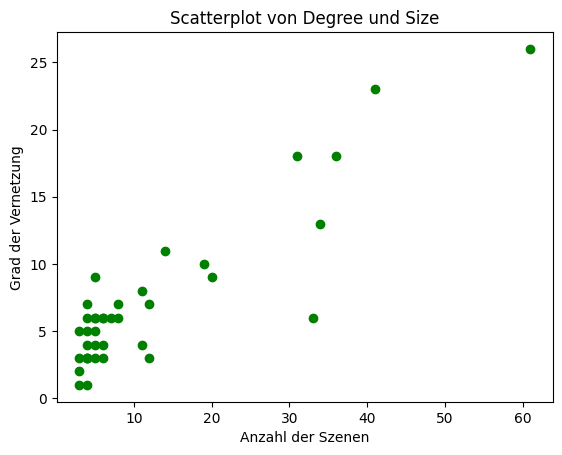

In [43]:
degrees = dict(graph_first_episode.degree())
values = nx.get_node_attributes(graph_first_episode, 'size')

degree_list = [degrees[node] for node in graph_first_episode.nodes()]
value_list = [values[node] for node in graph_first_episode.nodes()]

original_correlation, _ = pearsonr(degree_list, value_list)
print("Die originale Korrelation beträgt:", round(original_correlation,3))

plt.scatter(value_list, degree_list, color='green')
plt.title('Scatterplot von Degree und Size')
plt.ylabel('Grad der Vernetzung')
plt.xlabel('Anzahl der Szenen')
plt.show()

Die Pearson Korrelation zwischen dem Degree und der Anzahl Szenen ist mit 0.89 relativ, es gibt also einen Zusammenhang zwischen diesen beiden Variablen. Im Scatterplot wird allerdings ersichtlich, dass viele Charakteren in weniger als 10 Szenen auftauchen, der Degree aber von 1 bis 10 reicht. In der Praxis müsste man die Korrelation genauer untersuchen (Stichwort Scheinkorrelation und Ausreisser). Um die Funktionsweise des Hypothesentests aufzuzeigen, gehen wir hier davon aus, dass die Korrelation korrekt ist.

Nun führen wir die Permutation durch. Wir führen dazu 50'000 Permutationen durch und vermischen dabei immer die Werte in beiden Vektoren.

In [44]:
np.random.seed(42)

num_permutations = 50_000
significance_level = 0.05
count_greater = 0

lst_new_correlations = []

for _ in range(num_permutations):
    np.random.shuffle(value_list)
    np.random.shuffle(degree_list)
    permuted_correlation, _ = pearsonr(degree_list, value_list)
    lst_new_correlations.append(permuted_correlation)
    if permuted_correlation >= original_correlation:
        count_greater += 1

print("Anzahl neuer Korrelationen, die grösser sind:", count_greater)

p_value = count_greater / num_permutations

print("Der p-Wert beträgt:", p_value)

Anzahl neuer Korrelationen, die grösser sind: 0
Der p-Wert beträgt: 0.0


In den 50'000 Permutationen ist keine Korrelatioen höher als der originale Wert von 0.893. Das ist zwar eher überraschend, doch gemäss Definition können wir unsere Hypothese bestätigten, es gibt einen signifikanten Zusammenhang zwischen der Anzahl Szenen, in denen ein Charakter vorkommt und dessen Degree.

Aus Interesse plotten wir nun noch ein Histogramm, das die Verteilung der berechnete neuen Korrelationen aufzeigt und sie mit dem originalen Wert vergleicht.

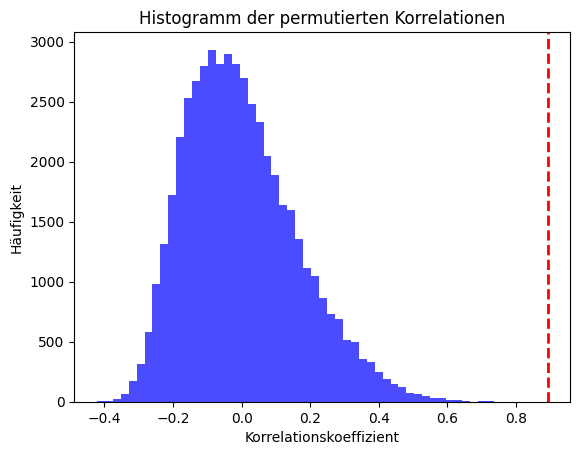

In [45]:
plt.hist(lst_new_correlations, bins=50, color='blue', alpha=0.7)
plt.axvline(x=original_correlation, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogramm der permutierten Korrelationen')
plt.xlabel('Korrelationskoeffizient')
plt.ylabel('Häufigkeit')
plt.show()

Dieses Histogramm bestätigt, dass der originale Korrelationskoeffizient deutlich höher als die neuen, aus der Permutation berechneten, Werte liegt und bestätigt visuell die Annahme der Hypothese.

# 8 Ausblick

Die Soziale Netzwerkanalyse unserer Starwars Krieger fanden wir sehr spannend und interessant. Wir haben viele neue Erkenntnisse gewonnen und konnten auch unsere erlernten Kenntnisse aus dem Modul Soziale Netzwerkanalyse anwenden. Wir haben uns sehr gefreut, dass wir die Möglichkeit hatten, dieses Projekt zu bearbeiten und möchten uns an dieser Stelle bei unseren Dozenten Michael Henninger bedanken. 

Durchaus hätte man noch weitere interessante Analyse durchführen können wie bsp. das Filtern nach bestimmten Species oder Attribute von Starwars Charakteren, wie wir dies im Kapitel 4, für die Entwicklung der Actor Zentralitätswerten versucht haben. Leider sind wir in dieser hinsicht jedoch begrenzt, da der Datensatz von Kaggle nicht alle Starwars Charaktere beinhaltet. Eine andere weitere spannende Analyse wäre noch die Gesprächsanalyse Bechel Test, welche uns die Gleichberechtigung der Geschlechter in den Starwars Filmen aufzeigt. Was aber widerum schwierig, ist da es unterschiedliche Geschlechter gibt und wir diese nicht einfach in zwei Kategorien aufteilen können, es wäre somit ein erweiterter Bechel Test spezifisch für Starwars.
